# ReneWind Project
##### 10/09/2023

## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [ ]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores and split data
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
)
from sklearn import metrics

# To impute missing values
from sklearn.impute import SimpleImputer

# To build models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline, make_pipeline

# Remove limit for number of displayed columns and rows
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# To suppress the warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# plot functions code source: DSBA IncomeGroupClassification_CaseStudy_DSBA_V2.ipynb
# histogram & boxplot function
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

## Loading the dataset

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load dataset from csv
load_train_df = pd.read_csv('/content/drive/MyDrive/DSBA/Model Tuning/project/Train.csv')
load_test_df = pd.read_csv('/content/drive/MyDrive/DSBA/Model Tuning/project/Test.csv')

# create copies to work with
train_df = load_train_df.copy()
test_df = load_test_df.copy()

## Data Overview

In [ ]:
# head of train data
train_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.464606,-4.679129,3.101546,0.506130,-0.221083,-2.032511,-2.910870,0.050714,-1.522351,3.761892,-5.714719,0.735893,0.981251,1.417884,-3.375815,-3.047303,0.306194,2.914097,2.269979,4.394876,-2.388299,0.646388,-1.190508,3.132986,0.665277,-2.510846,-0.036744,0.726218,-3.982187,-1.072638,1.667098,3.059700,-1.690440,2.846296,2.235198,6.667486,0.443809,-2.369169,2.950578,-3.480324,0
1,3.365912,3.653381,0.909671,-1.367528,0.332016,2.358938,0.732600,-4.332135,0.565695,-0.101080,1.914465,-0.951458,-1.255259,-2.706522,0.193223,-4.769379,-2.205319,0.907716,0.756894,-5.833678,-3.065122,1.596647,-1.757311,1.766444,-0.267098,3.625036,1.500346,-0.585712,0.783034,-0.201217,0.024883,-1.795474,3.032780,-2.467514,1.894599,-2.297780,-1.731048,5.908837,-0.386345,0.616242,0
2,-3.831843,-5.824444,0.634031,-2.418815,-1.773827,1.016824,-2.098941,-3.173204,-2.081860,5.392621,-0.770673,1.106718,1.144261,0.943301,-3.163804,-4.247825,-4.038909,3.688534,3.311196,1.059002,-2.143026,1.650120,-1.660592,1.679910,-0.450782,-4.550695,3.738779,1.134404,-2.033531,0.840839,-1.600395,-0.257101,0.803550,4.086219,2.292138,5.360850,0.351993,2.940021,3.839160,-4.309402,0
3,1.618098,1.888342,7.046143,-1.147285,0.083080,-1.529780,0.207309,-2.493629,0.344926,2.118578,-3.053023,0.459719,2.704527,-0.636086,-0.453717,-3.174046,-3.404347,-1.281536,1.582104,-1.951778,-3.516555,-1.206011,-5.627854,-1.817653,2.124142,5.294642,4.748137,-2.308536,-3.962977,-6.028730,4.948770,-3.584425,-2.577474,1.363769,0.622714,5.550100,-1.526796,0.138853,3.101430,-1.277378,0
4,-0.111440,3.872488,-3.758361,-2.982897,3.792714,0.544960,0.205433,4.848994,-1.854920,-6.220023,1.998347,4.723757,0.709113,-1.989432,-2.632684,4.184447,2.245356,3.734452,-6.312766,-5.379918,-0.886667,2.061694,9.445586,4.489976,-3.945144,4.582065,-8.780422,-3.382967,5.106507,6.787513,2.044184,8.265896,6.629213,-10.068689,1.222987,-3.229763,1.686909,-2.163896,-3.644622,6.510338,0


In [ ]:
# tail of train data
train_df.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
19995,-2.071318,-1.088279,-0.796174,-3.011720,-2.287540,2.807310,0.481428,0.105171,-0.586599,-2.899398,8.868415,1.717155,1.357838,-1.777135,0.709780,4.944939,-3.100454,-1.199228,-1.084629,-0.365044,3.131175,-3.948103,-3.578469,-8.139067,-1.936861,-1.327691,-0.402688,-1.734796,9.996461,6.955367,-3.938493,-8.273996,5.745013,0.589014,-0.649988,-3.043174,2.216461,0.608723,0.178193,2.927755,1
19996,2.890264,2.483069,5.643919,0.937053,-1.380870,0.412051,-1.593386,-5.762498,2.150096,0.272302,-2.094760,-1.525834,0.071573,-3.540142,-2.762006,-10.632206,-0.495236,1.720074,3.871596,-1.209610,-8.222073,2.120866,-5.491808,1.452340,1.450002,3.684654,1.076760,-0.384175,-0.838593,-0.748275,-1.088553,-4.159092,1.181466,-0.742412,5.368979,-0.693028,-1.668971,3.659954,0.819863,-1.987265,0
19997,-3.896979,-3.942407,-0.351364,-2.417462,1.107546,-1.527623,-3.519882,2.054792,-0.233996,-0.357687,-3.781972,2.180042,6.111780,1.984747,-8.330002,-1.639184,-0.914960,5.672348,-3.924200,2.133196,-4.502031,2.777178,5.727949,1.619818,-1.699691,-0.041882,-2.923094,-2.760158,-2.253766,2.552033,0.981858,7.112162,1.476080,-3.953710,1.855555,5.029209,2.082588,-6.409304,1.477138,-0.874148,0
19998,-3.187322,-10.051662,5.695955,-4.370053,-5.354758,-1.873044,-3.947210,0.679420,-2.389254,5.456756,1.583029,3.571478,9.226573,2.553587,-7.039109,-0.993573,-9.664938,1.155224,3.876895,3.523634,-7.015329,-0.132037,-3.446179,-4.801443,-0.875727,-3.811854,5.422077,-3.732322,0.608811,5.256460,1.914766,0.402812,3.163661,3.752095,8.529894,8.450626,0.203958,-7.129918,4.249394,-6.112267,0
19999,-2.686903,1.961187,6.137088,2.600133,2.657241,-4.290882,-2.344267,0.974004,-1.027462,0.497421,-9.589075,3.176560,1.054517,-1.415882,-4.668611,-5.405377,3.719759,2.892923,2.328591,1.457704,-6.428543,1.818232,0.805897,7.786026,0.330857,5.257424,-4.867417,-0.818941,-5.667393,-2.860975,4.674280,6.620811,-1.988786,-1.348901,3.951801,5.449706,-0.455411,-2.202056,1.678229,-1.974413,0


In [ ]:
# head of test data
test_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613489,-3.819640,2.202302,1.300420,-1.184929,-4.495964,-1.835817,4.722989,1.206140,-0.341909,-5.122874,1.017021,4.818549,3.269001,-2.984330,1.387370,2.032002,-0.511587,-1.023069,7.338733,-2.242244,0.155489,2.053786,-2.772273,1.851369,-1.788696,-0.277282,-1.255143,-3.832886,-1.504542,1.586765,2.291204,-5.411388,0.870073,0.574479,4.157191,1.428093,-10.511342,0.454664,-1.448363,0
1,0.389608,-0.512341,0.527053,-2.576776,-1.016766,2.235112,-0.441301,-4.405744,-0.332869,1.966794,1.796544,0.410490,0.638328,-1.389600,-1.883410,-5.017922,-3.827238,2.418060,1.762285,-3.242297,-3.192960,1.857454,-1.707954,0.633444,-0.587898,0.083683,3.013935,-0.182309,0.223917,0.865228,-1.782158,-2.474936,2.493582,0.315165,2.059288,0.683859,-0.485452,5.128350,1.720744,-1.488235,0
2,-0.874861,-0.640632,4.084202,-1.590454,0.525855,-1.957592,-0.695367,1.347309,-1.732348,0.466500,-4.928214,3.565070,-0.449329,-0.656246,-0.166537,-1.630207,2.291865,2.396492,0.601278,1.793534,-2.120238,0.481968,-0.840707,1.790197,1.874395,0.363930,-0.169063,-0.483832,-2.118982,-2.156586,2.907291,-1.318888,-2.997464,0.459664,0.619774,5.631504,1.323512,-1.752154,1.808302,1.675748,0
3,0.238384,1.458607,4.014528,2.534478,1.196987,-3.117330,-0.924035,0.269493,1.322436,0.702345,-5.578345,-0.850662,2.590525,0.767418,-2.390809,-2.341961,0.571875,-0.933751,0.508677,1.210715,-3.259524,0.104587,-0.658875,1.498107,1.100305,4.142988,-0.248446,-1.136516,-5.355810,-4.545931,3.808667,3.517918,-3.074085,-0.284220,0.954576,3.029331,-1.367198,-3.412140,0.906000,-2.450889,0
4,5.828225,2.768260,-1.234530,2.809264,-1.641648,-1.406698,0.568643,0.965043,1.918379,-2.774855,-0.530016,1.374544,-0.650941,-1.679466,-0.379220,-4.443143,3.893857,-0.607640,2.944931,0.367233,-5.789081,4.597528,4.450264,3.224941,0.396701,0.247765,-2.362047,1.079378,-0.473076,2.242810,-3.591421,1.773841,-1.501573,-2.226702,4.776830,-6.559698,-0.805551,-0.276007,-3.858207,-0.537694,0


In [ ]:
# tail of test data
test_df.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
4995,-5.120451,1.634804,1.251259,4.035944,3.291204,-2.932230,-1.328662,1.754066,-2.984586,1.248633,-6.877747,3.715160,-2.511806,-1.394968,-2.554137,-2.197372,4.771707,2.402944,3.791758,0.486773,-2.028078,1.777923,3.667993,11.374878,-1.977092,2.251588,-7.318514,1.906959,-3.733697,-0.012451,2.120487,9.979118,0.063438,0.217281,3.036388,2.109323,-0.557433,1.938718,0.512674,-2.694194,0
4996,-5.172498,1.171653,1.579105,1.219922,2.529627,-0.668648,-2.618321,-2.000545,0.633791,-0.578938,-3.671247,0.460184,3.320582,-1.074959,-7.112535,-4.355946,-0.001086,3.698440,-0.846390,-0.222274,-3.644960,0.736036,0.925657,3.277684,-2.276759,4.457628,-4.542885,-1.348010,-1.779429,0.352203,-0.214294,4.423900,2.603811,-2.152170,0.917401,2.156586,0.466963,0.470120,2.196756,-2.376515,0
4997,-1.114136,-0.403576,-1.764875,-5.879475,3.571558,3.710802,-2.482952,-0.307614,-0.921945,-2.999141,-0.111655,-1.976921,-1.622992,-0.945453,-2.735095,-0.813009,0.609751,8.148839,-9.199173,-3.872479,-0.295705,1.468382,2.884317,2.792106,-1.135704,1.197920,-4.341677,-2.869396,4.124074,4.196731,3.470723,3.791778,7.481506,-10.061396,-0.387166,1.848509,1.818248,-1.245633,-1.260876,7.474682,0
4998,-1.703241,0.614650,6.220503,-0.104132,0.955916,-3.278706,-1.633855,-0.103936,1.388152,-1.065622,-7.969807,2.262126,3.134010,-0.485755,-3.498287,-4.561709,3.135784,2.536404,-0.792224,4.398442,-4.073022,-0.037573,-2.371253,-1.541981,2.907892,3.214506,-0.168668,-1.541327,-4.724387,-5.525040,1.667974,-4.100352,-5.949325,0.550372,-1.573640,6.823936,2.139307,-4.036164,3.436051,0.579249,0
4999,-0.603701,0.959550,-0.720995,8.229574,-1.815610,-2.275547,-2.574524,-1.041479,4.129645,-2.731288,-3.292371,-1.673752,0.464506,-1.645933,-5.263407,-7.987625,6.480488,0.226333,4.963336,6.752006,-6.305771,3.270541,1.897225,3.270810,-0.637079,-0.924996,-6.758918,2.990181,-0.813841,3.498989,-8.434720,2.369776,-1.062408,0.790772,4.951955,-7.440825,-0.069506,-0.918083,-2.291154,-5.362891,0


In [ ]:
# display shape of train data
train_df.shape

(20000, 41)

In [ ]:
# display shape of test data
test_df.shape

(5000, 41)

In [ ]:
# view column info on train
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [ ]:
# check for missing values in train data
train_df.isna().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

In [ ]:
# check for duplcate rows in train data
train_df.duplicated().sum()

0

- There are several null values in the dataset
- There are no duplicative rows in the dataset

In [ ]:
# describe numerical data
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,19982.0,-0.271996,3.441625,-11.876451,-2.737146,-0.747917,1.840112,15.493002
V2,19982.0,0.440430,3.150784,-12.319951,-1.640674,0.471536,2.543967,13.089269
V3,20000.0,2.484699,3.388963,-10.708139,0.206860,2.255786,4.566165,17.090919
V4,20000.0,-0.083152,3.431595,-15.082052,-2.347660,-0.135241,2.130615,13.236381
V5,20000.0,-0.053752,2.104801,-8.603361,-1.535607,-0.101952,1.340480,8.133797
V6,20000.0,-0.995443,2.040970,-10.227147,-2.347238,-1.000515,0.380330,6.975847
V7,20000.0,-0.879325,1.761626,-7.949681,-2.030926,-0.917179,0.223695,8.006091
V8,20000.0,-0.548195,3.295756,-15.657561,-2.642665,-0.389085,1.722965,11.679495
V9,20000.0,-0.016808,2.160568,-8.596313,-1.494973,-0.067597,1.409203,8.137580
V10,20000.0,-0.012998,2.193201,-9.853957,-1.411212,0.100973,1.477045,8.108472


## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

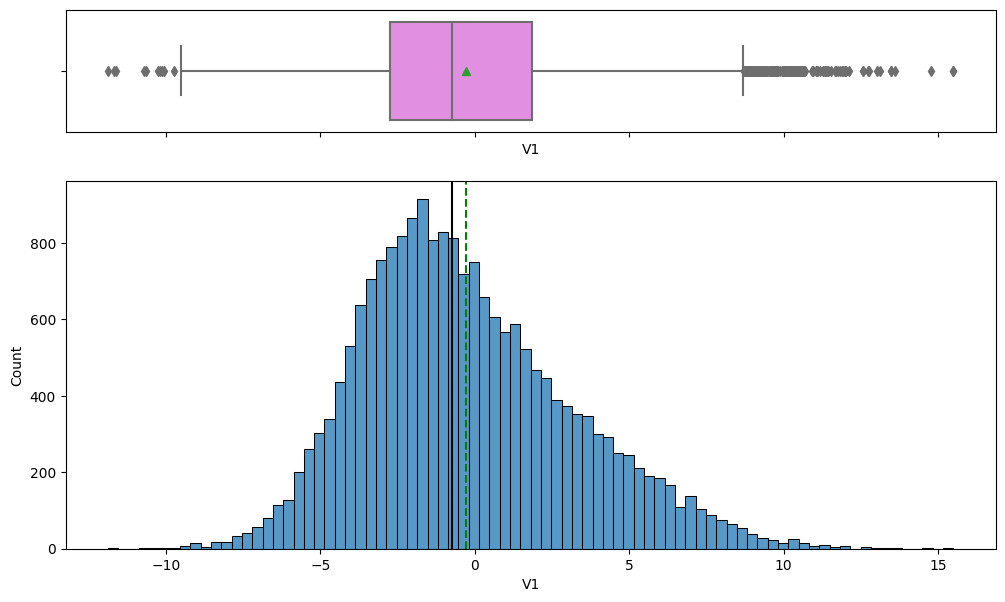

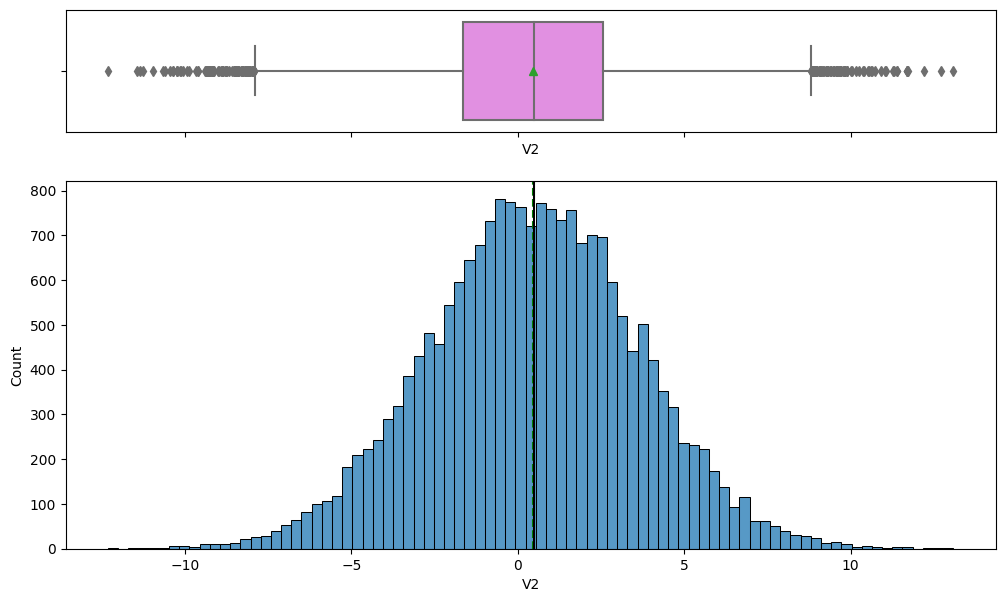

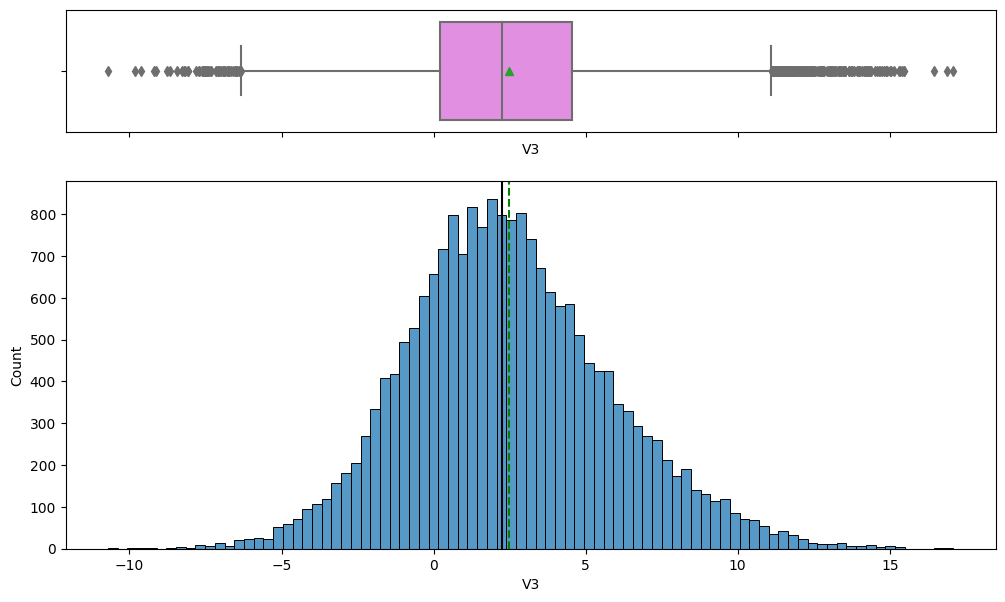

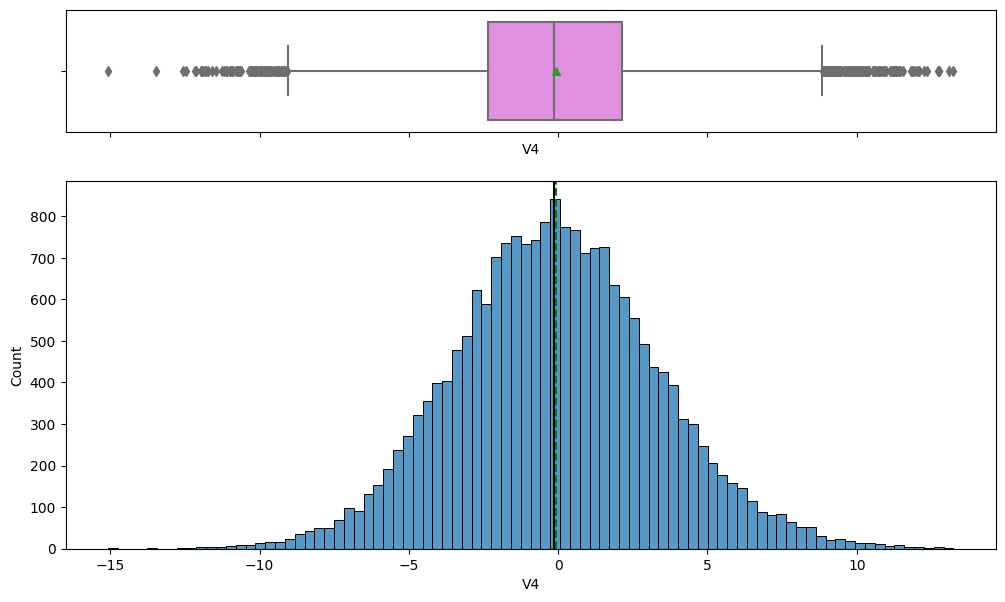

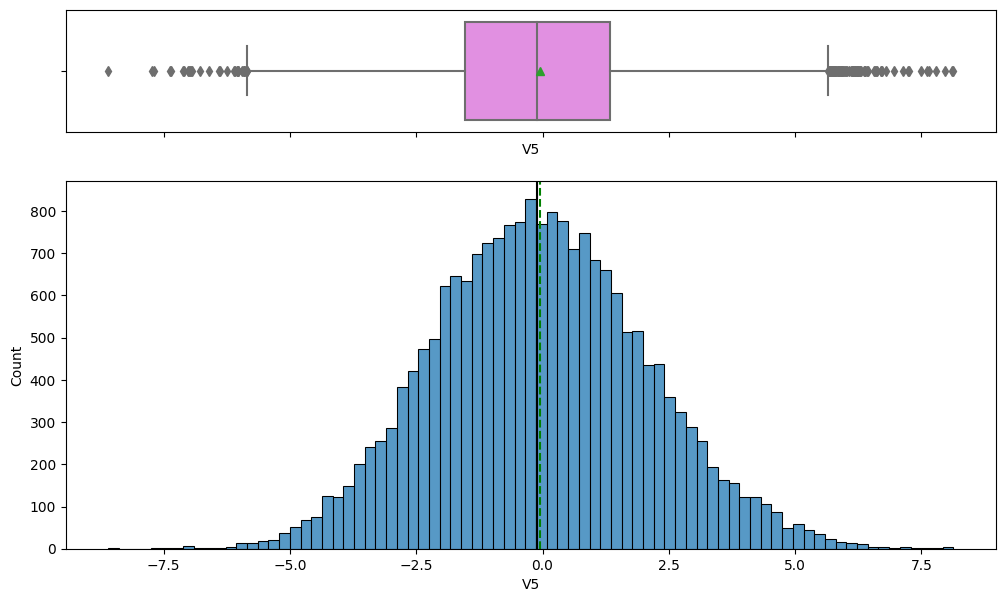

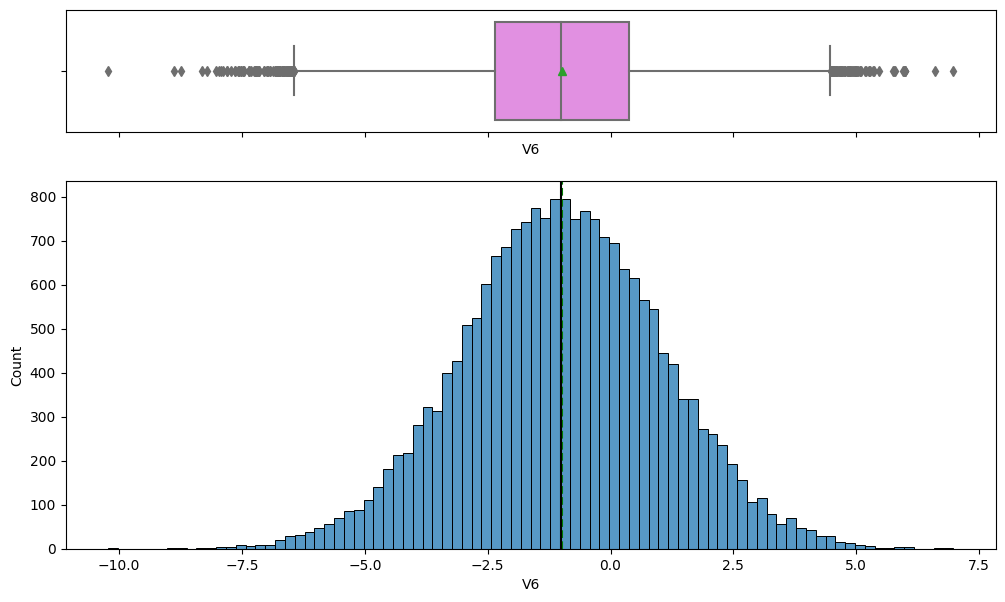

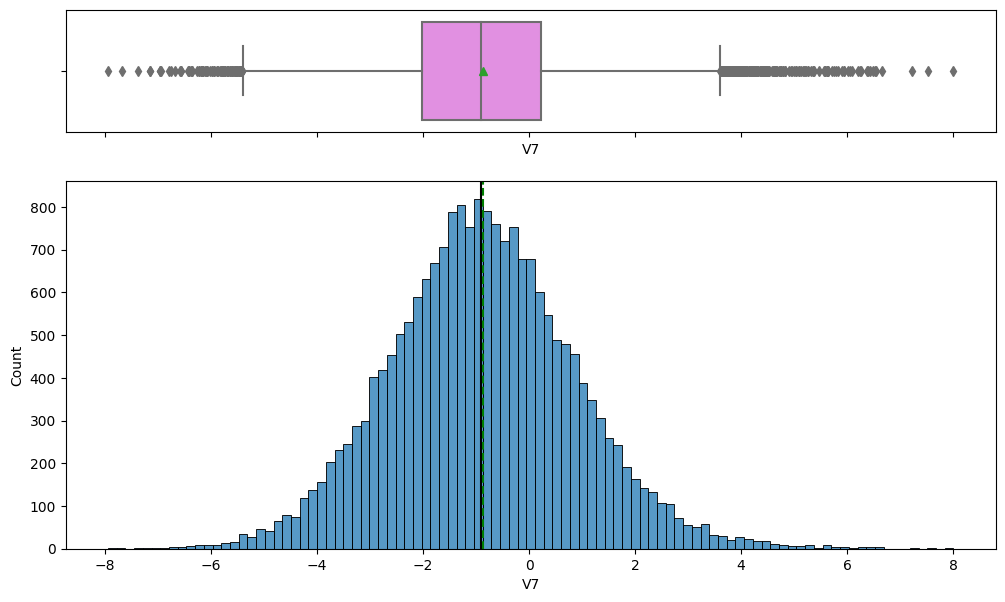

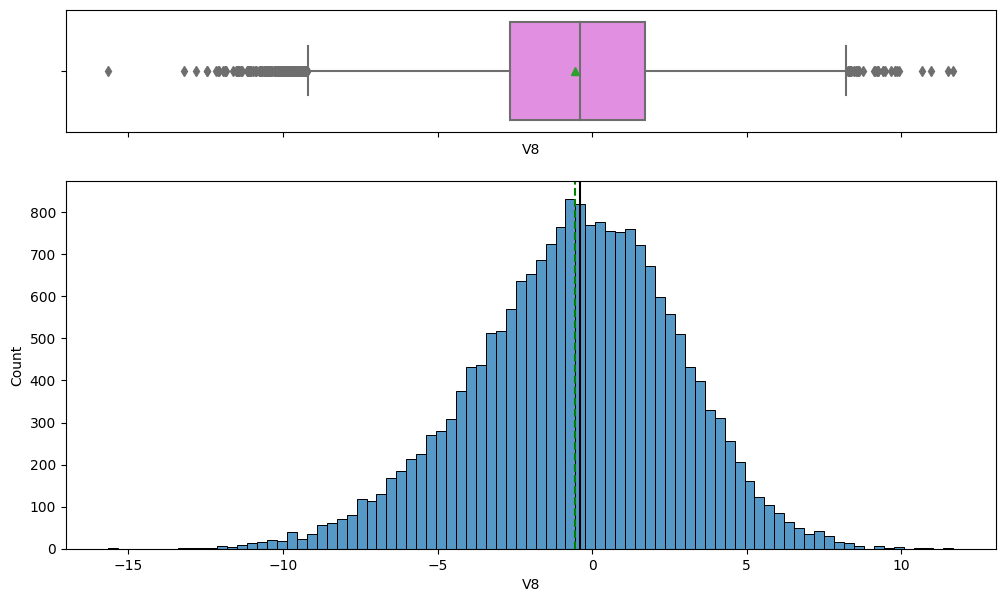

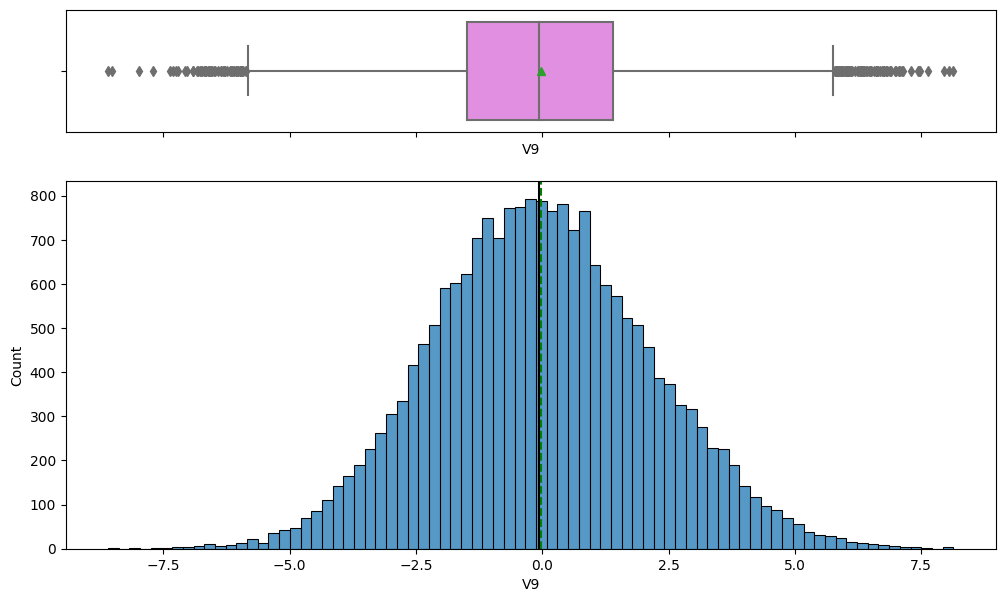

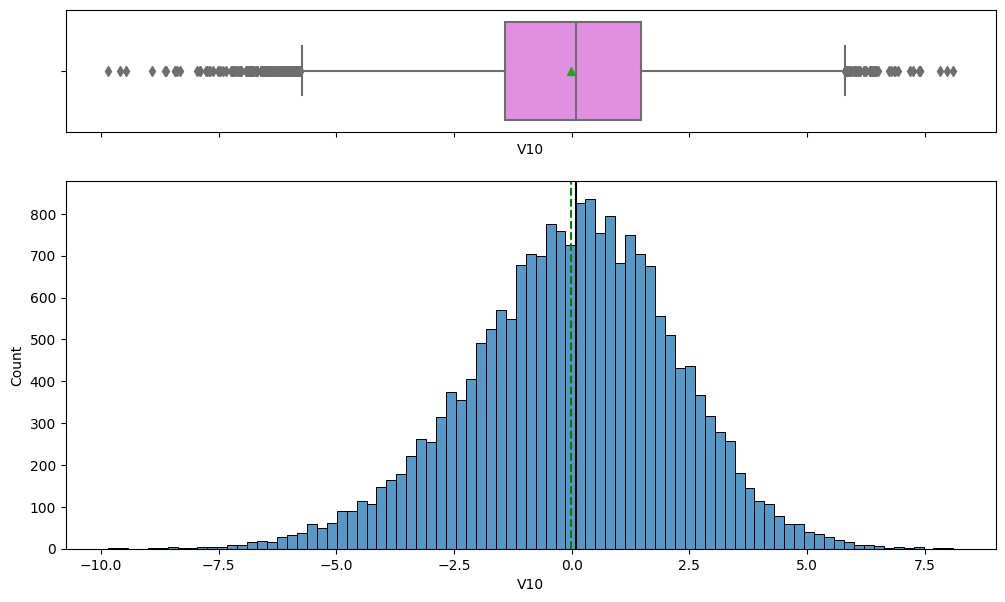

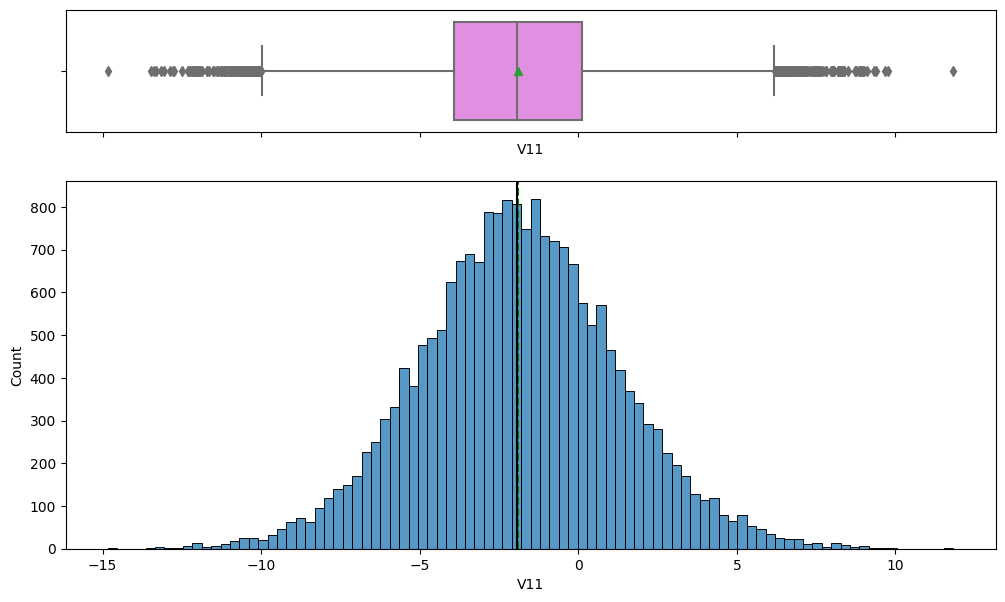

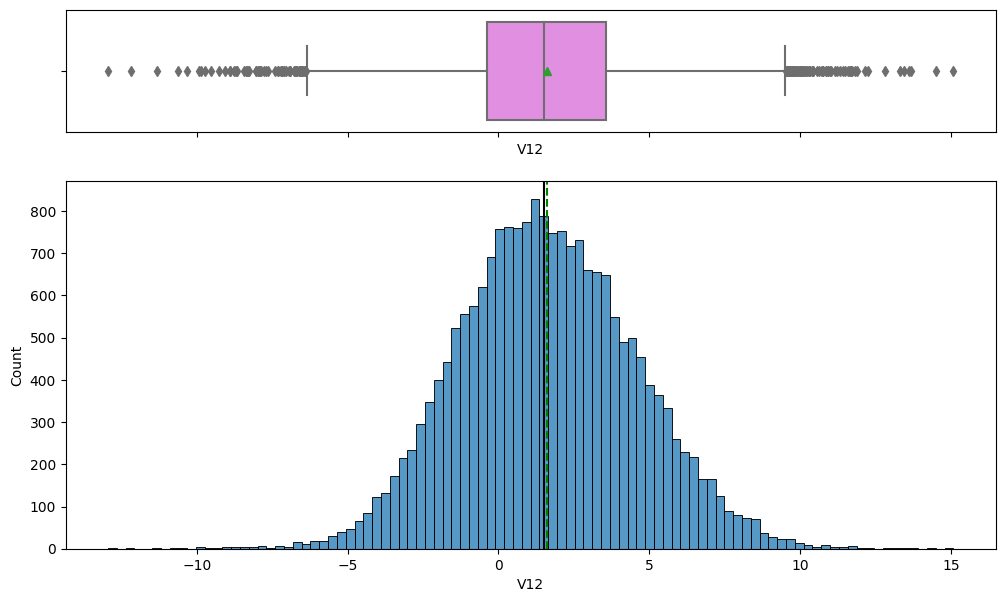

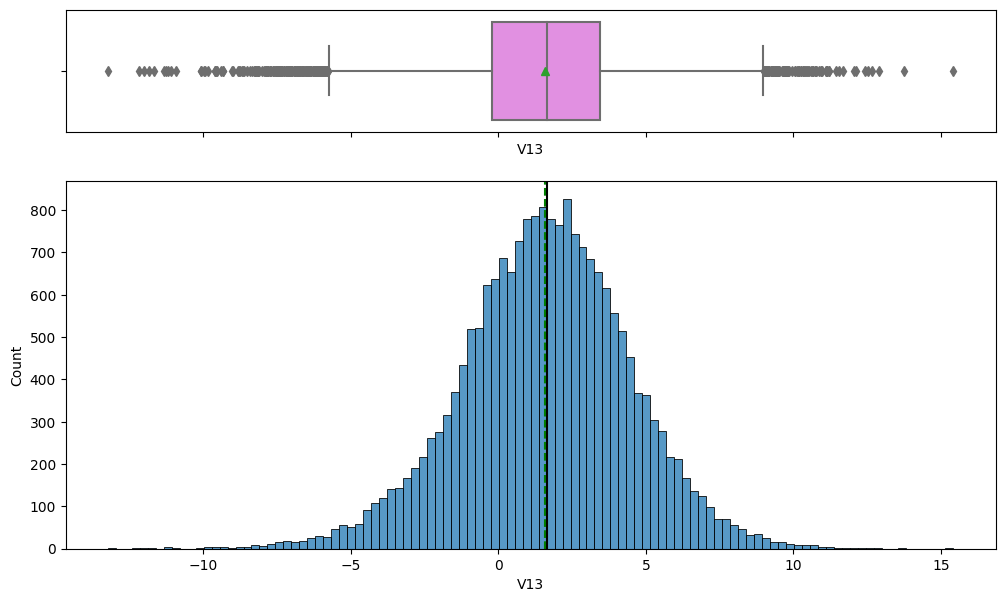

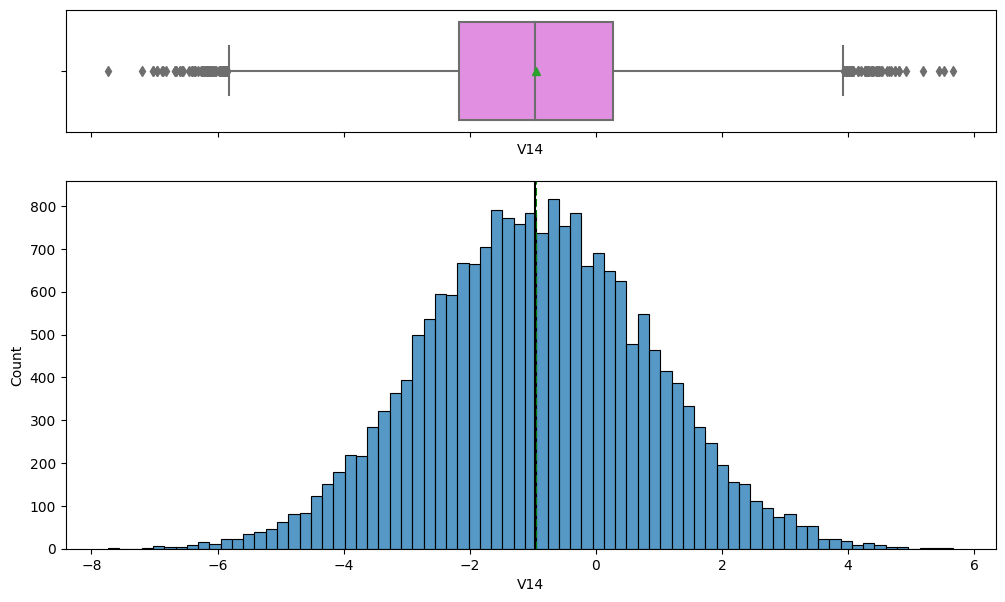

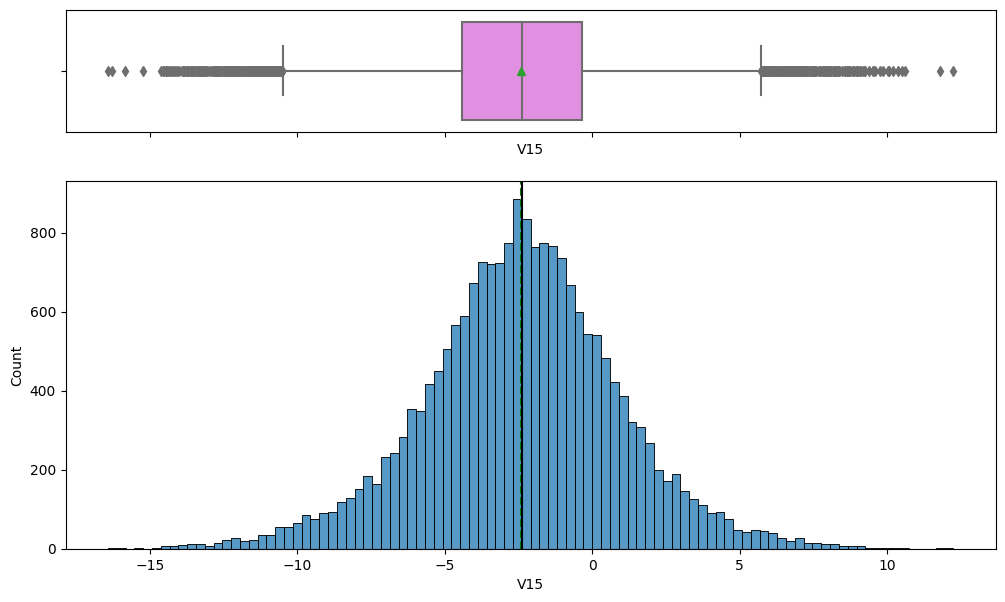

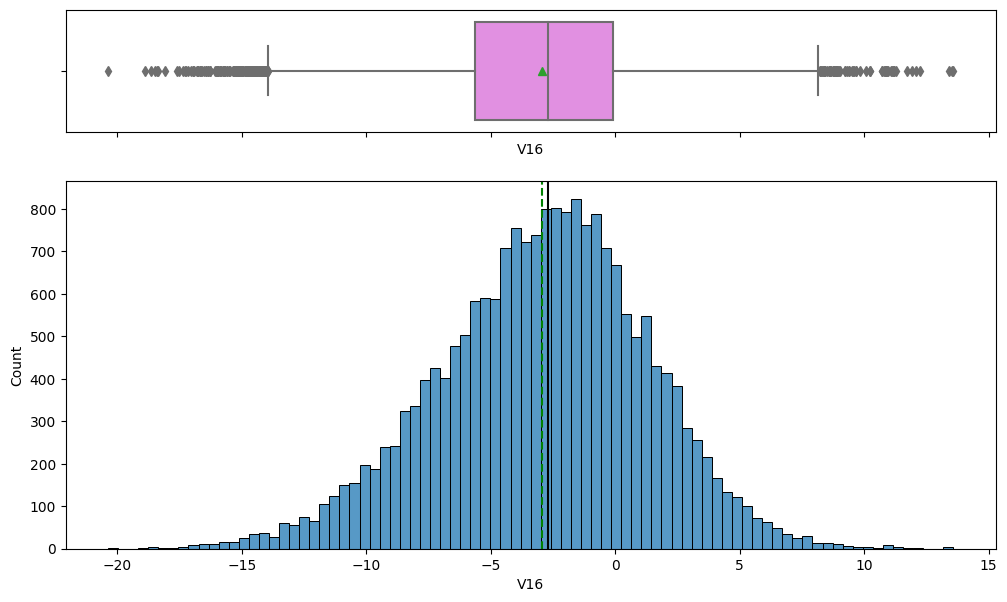

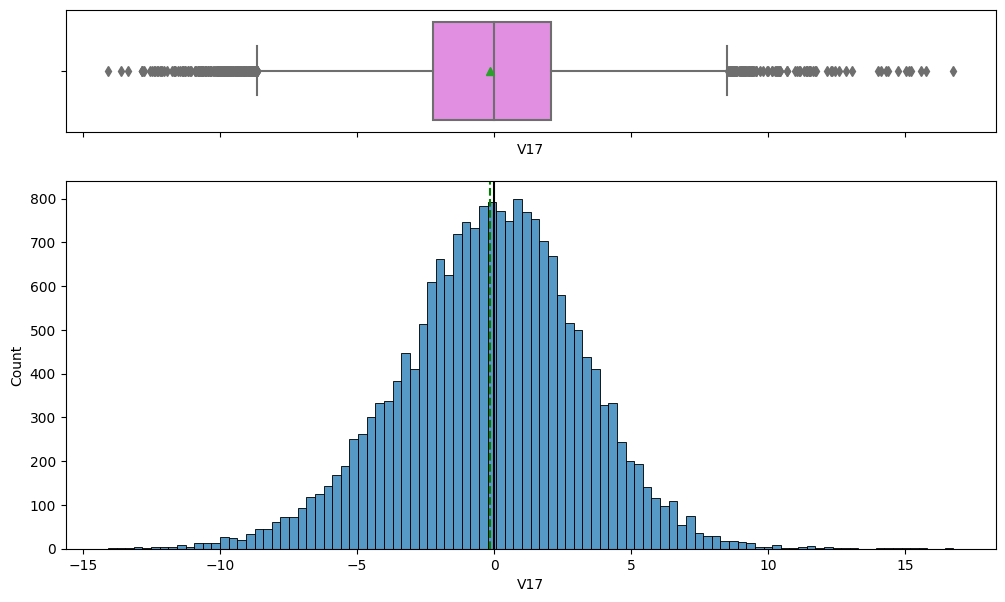

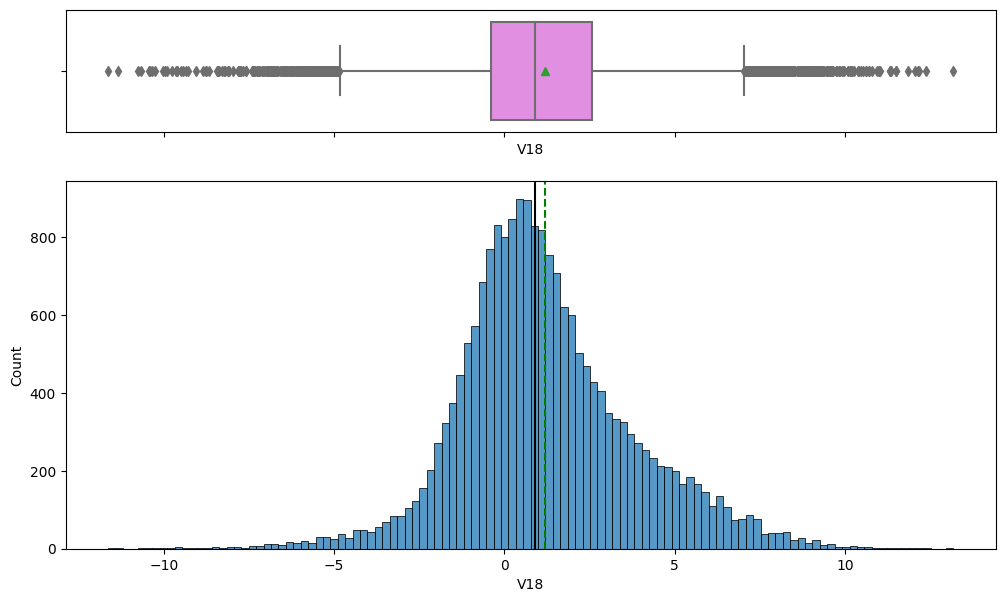

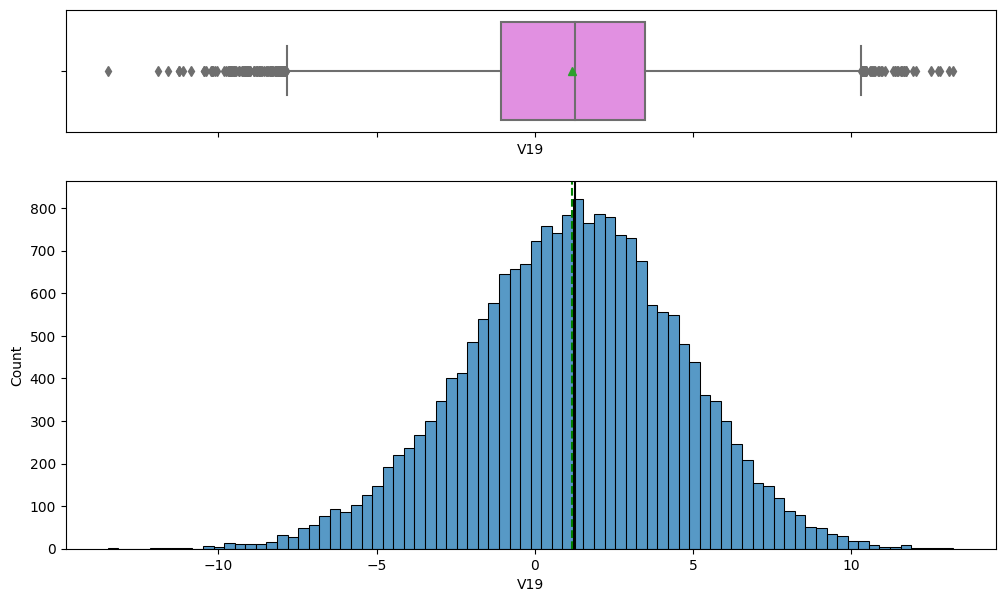

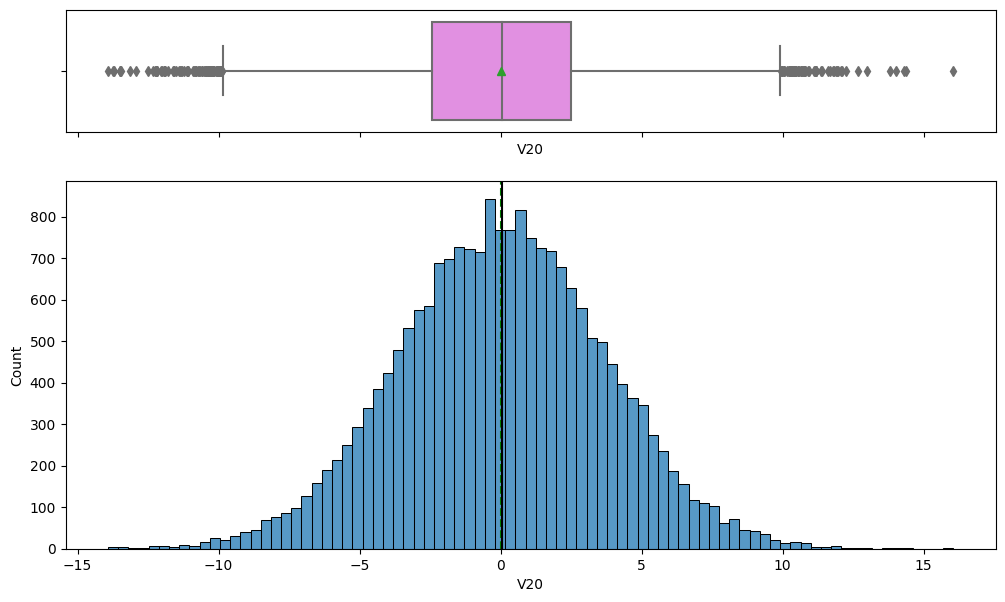

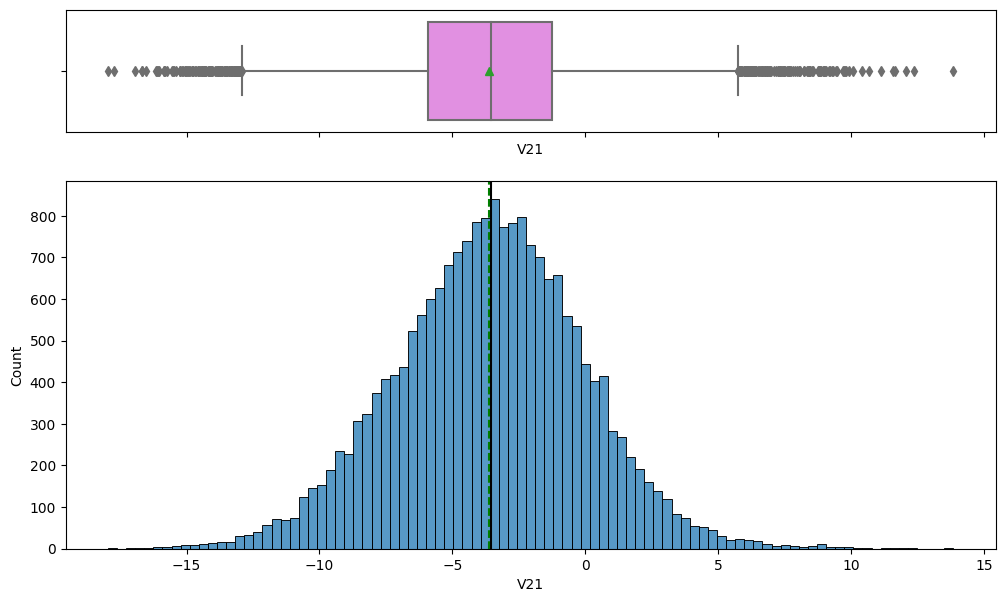

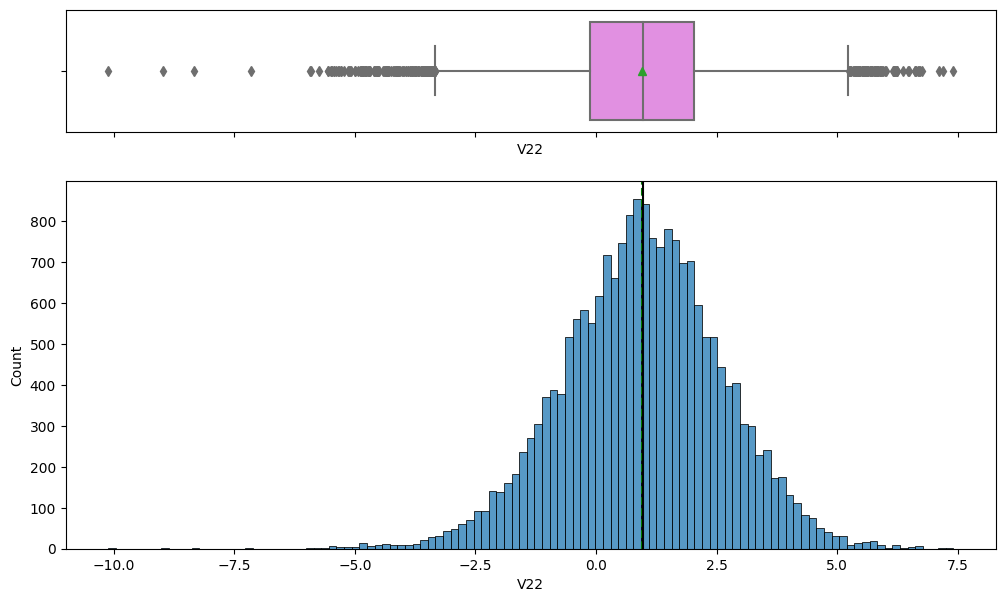

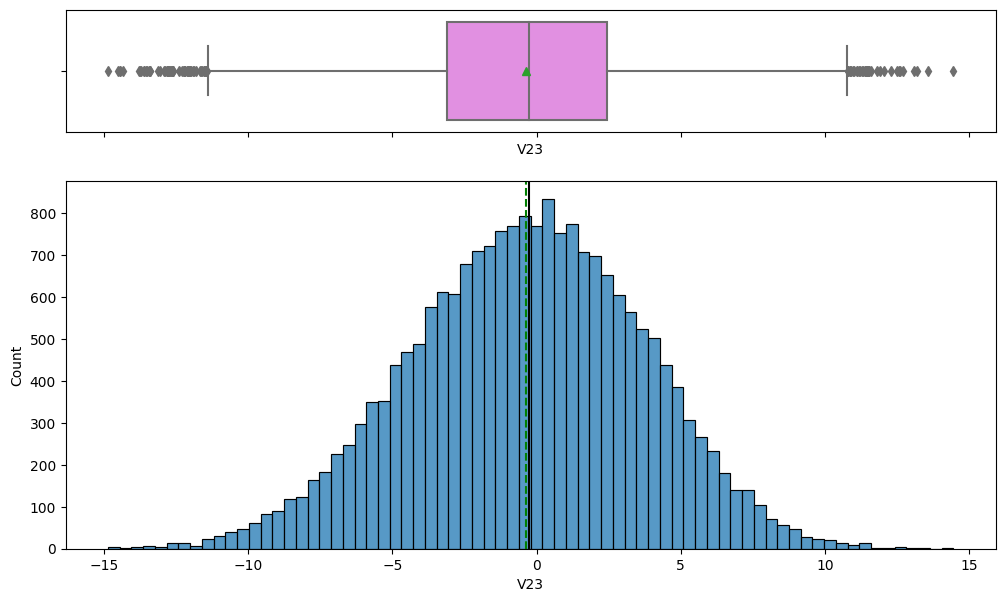

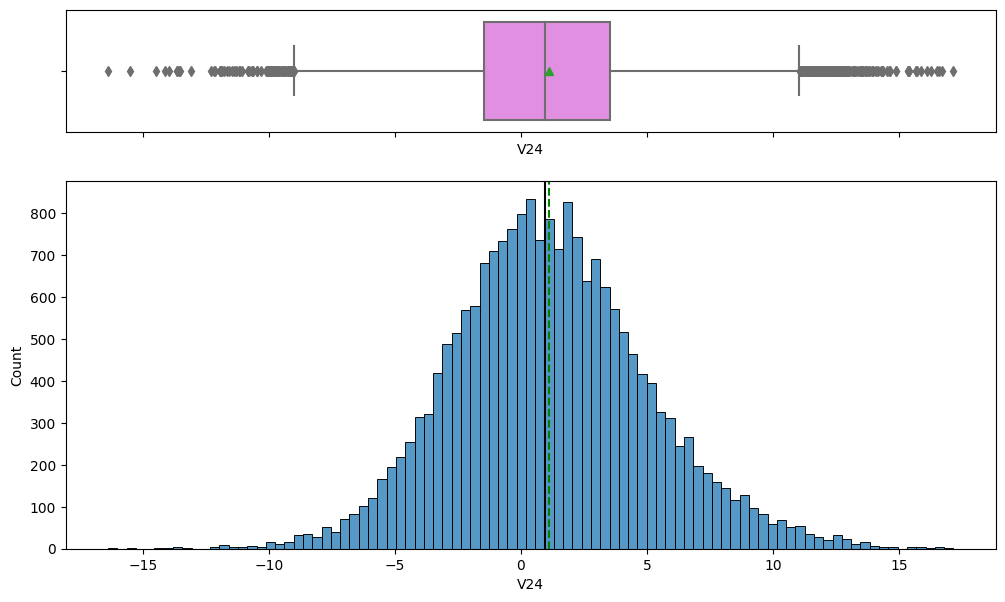

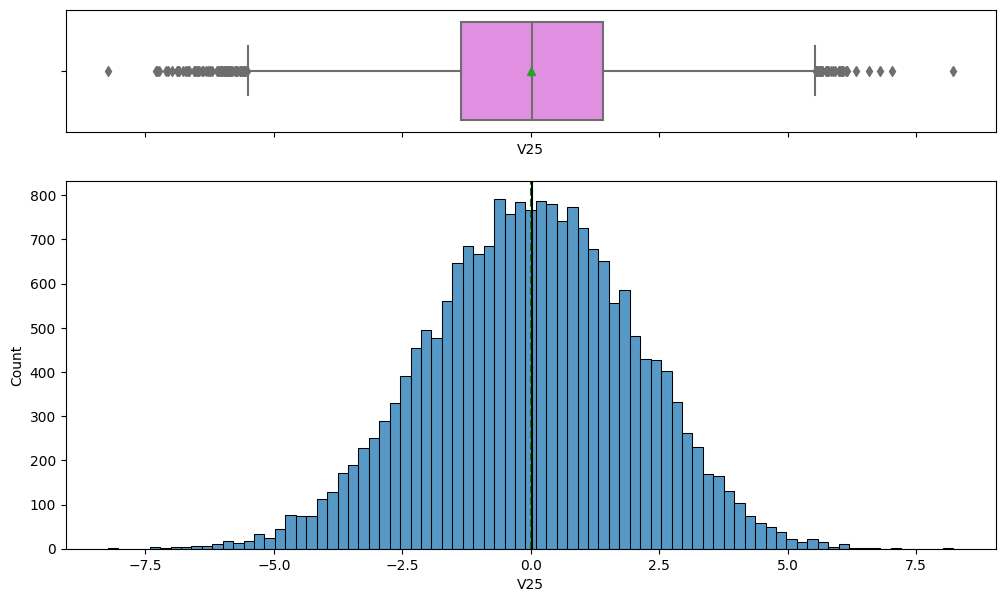

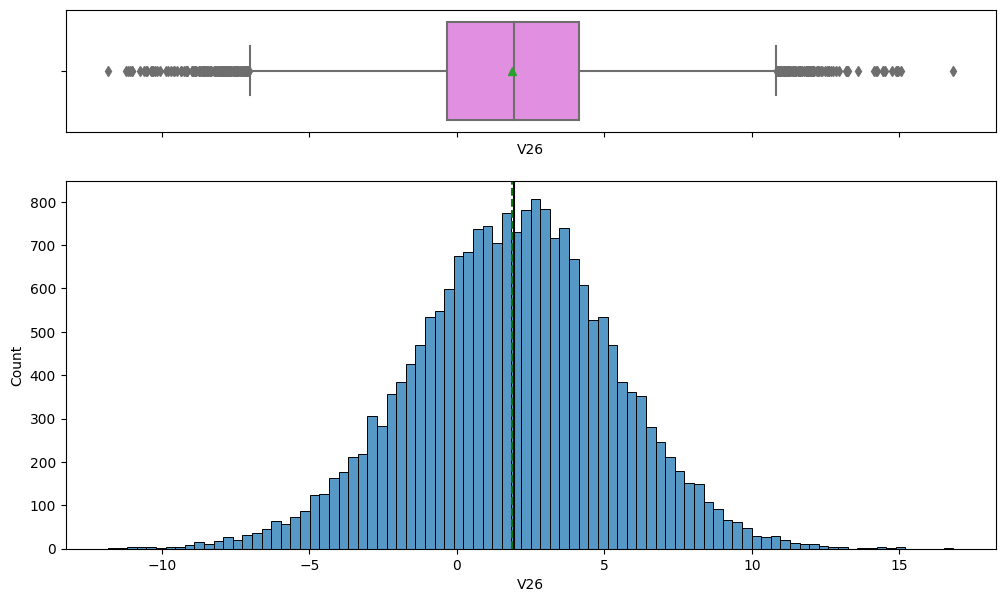

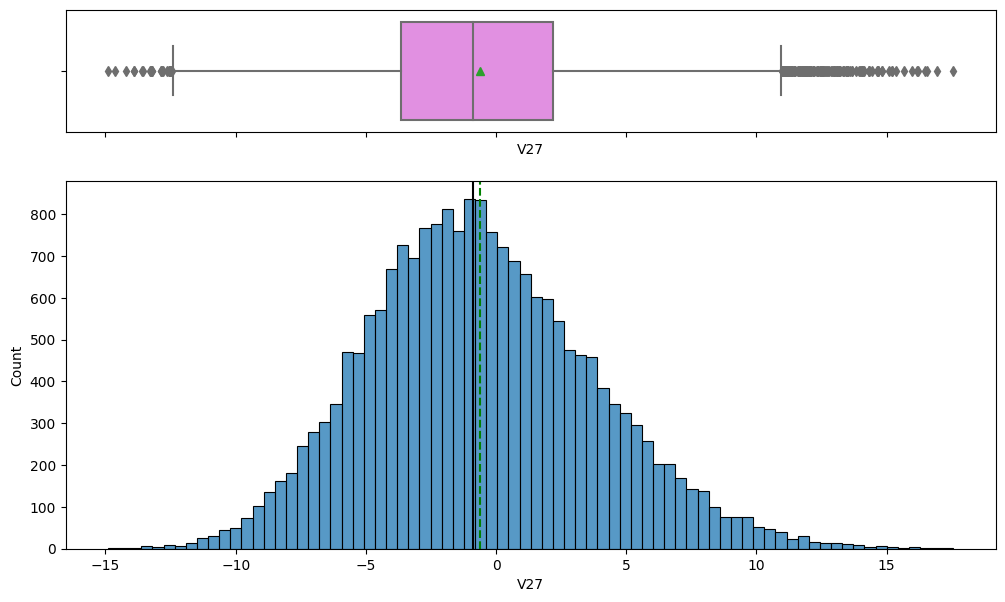

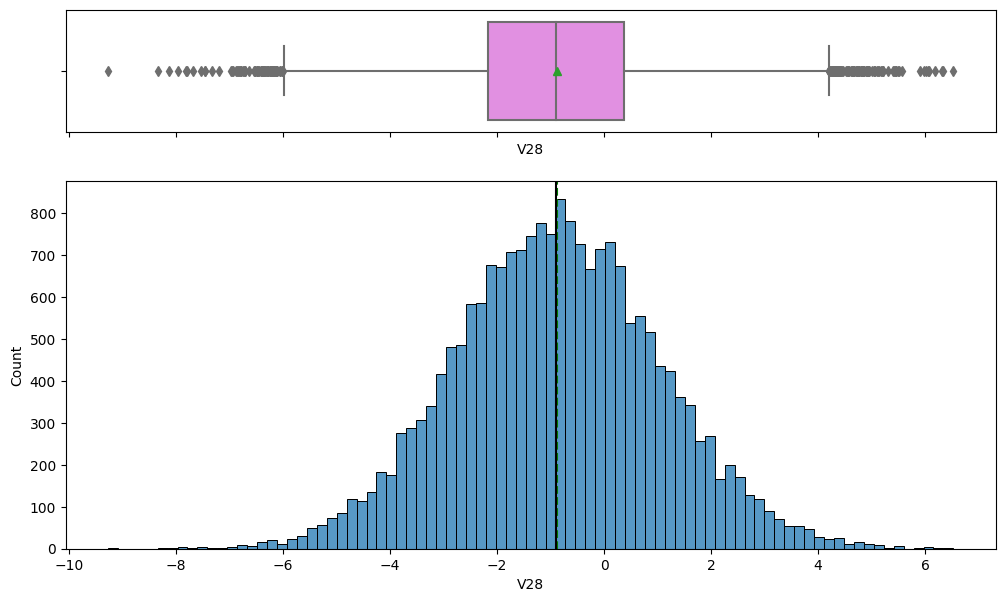

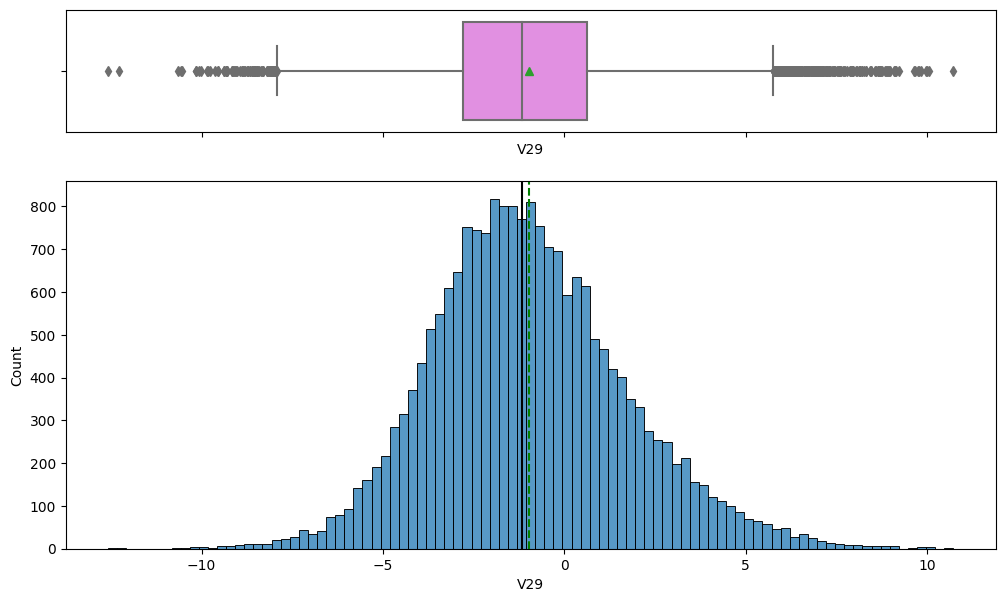

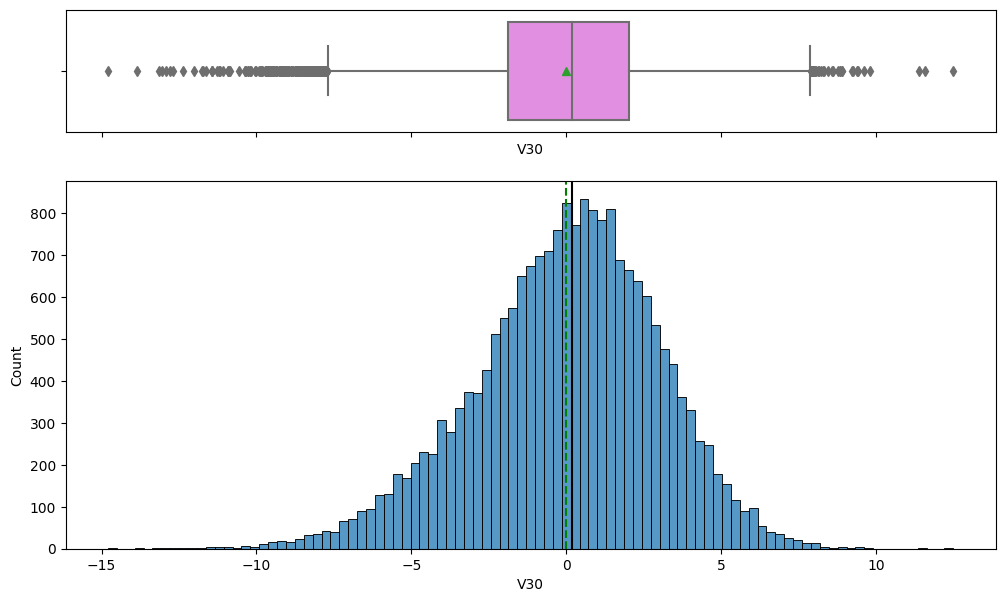

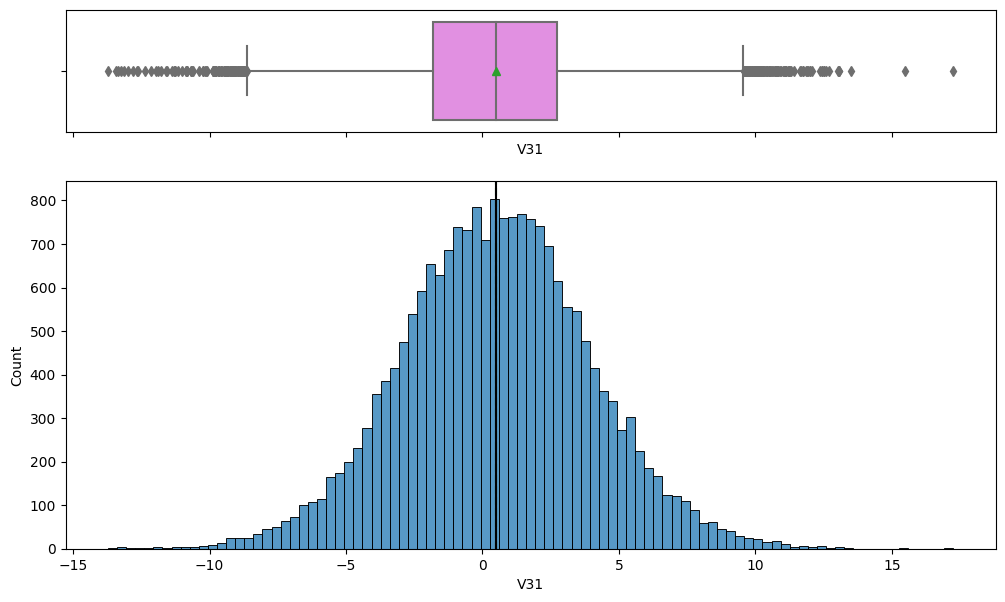

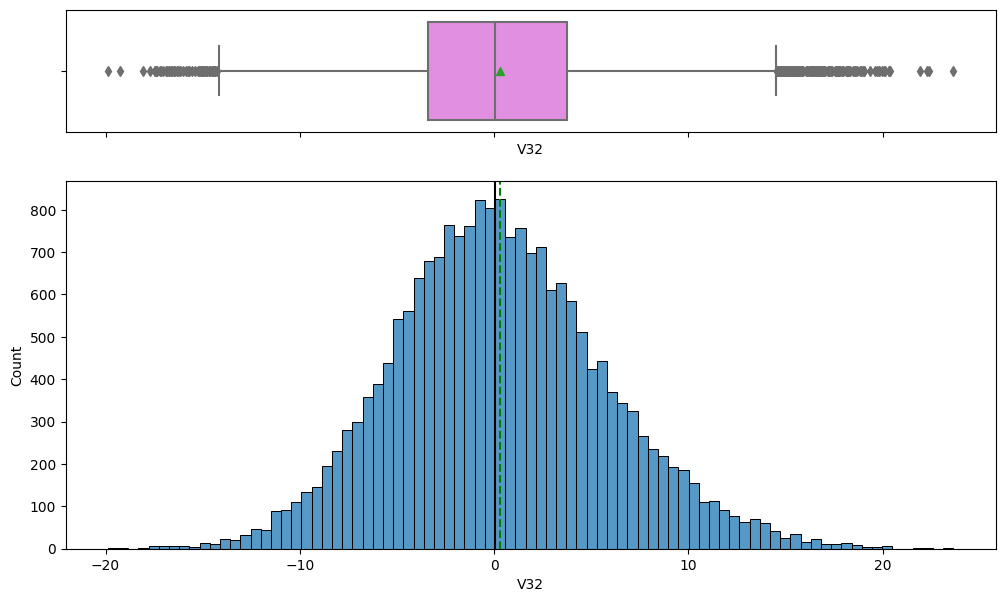

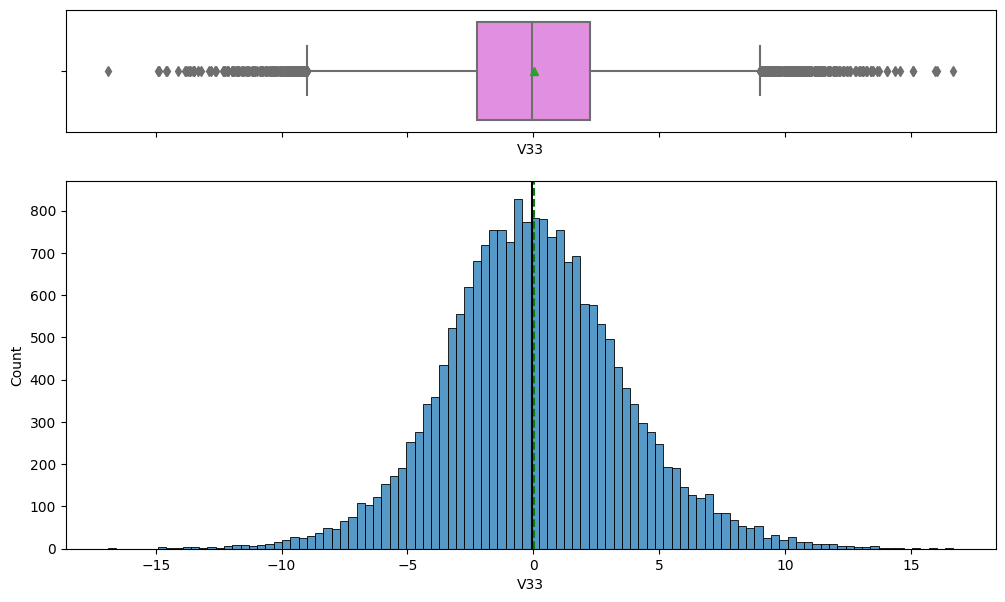

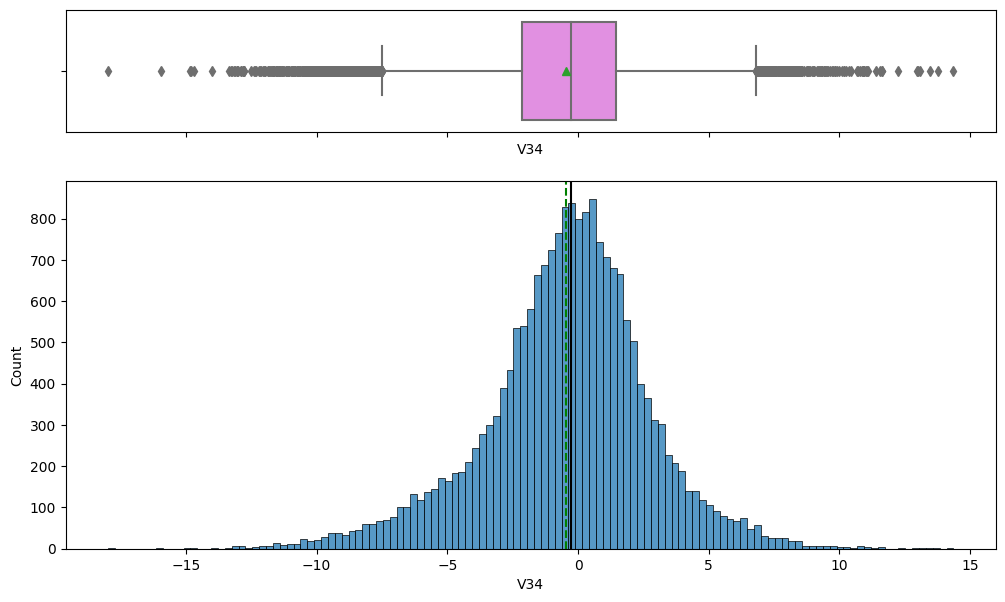

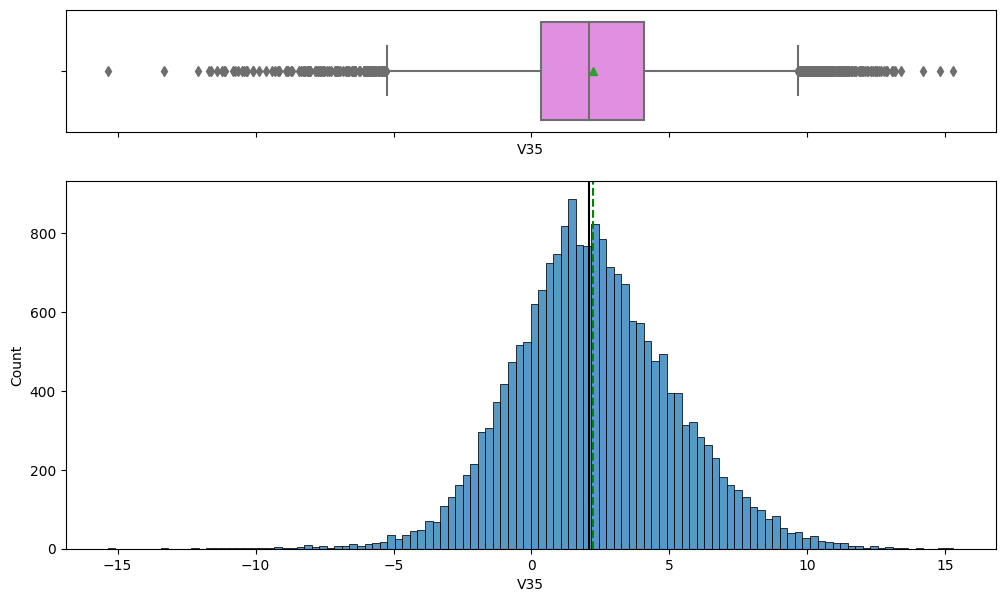

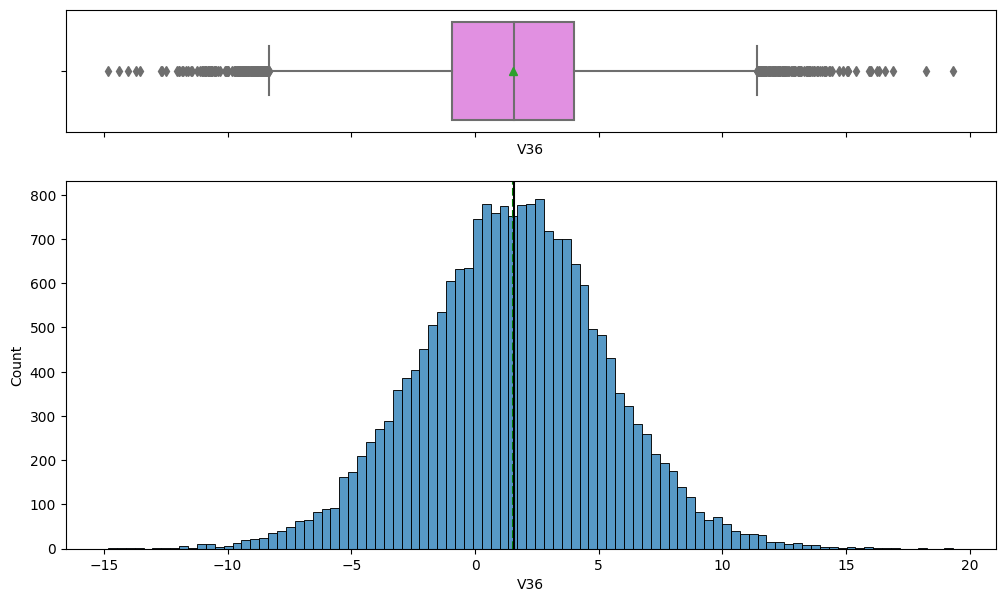

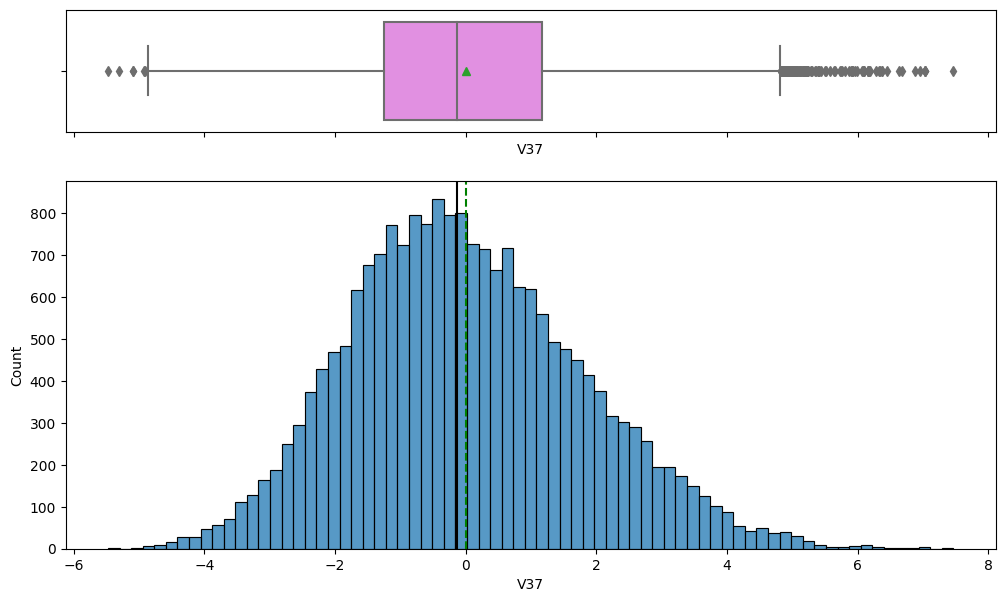

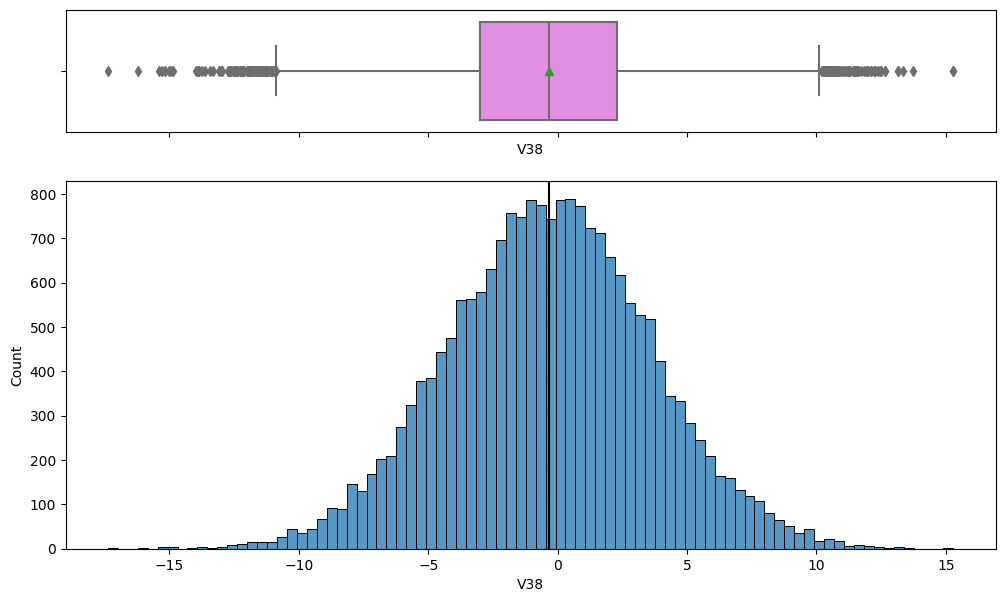

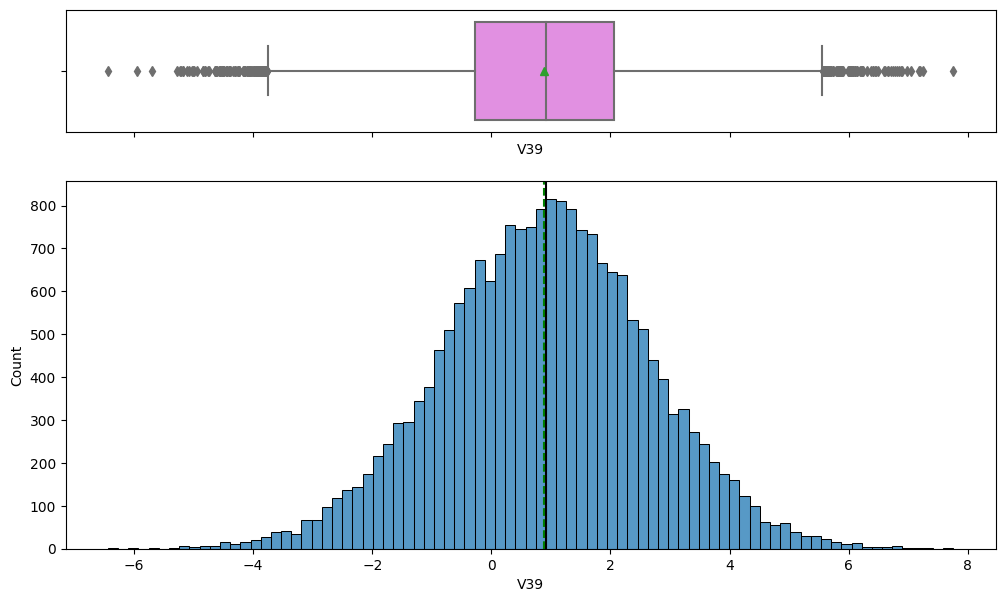

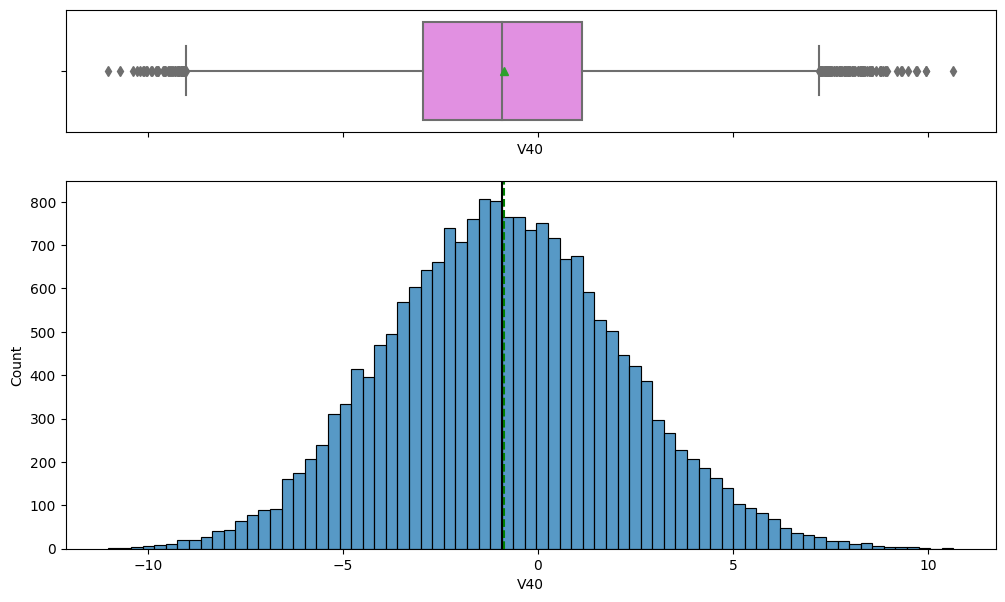

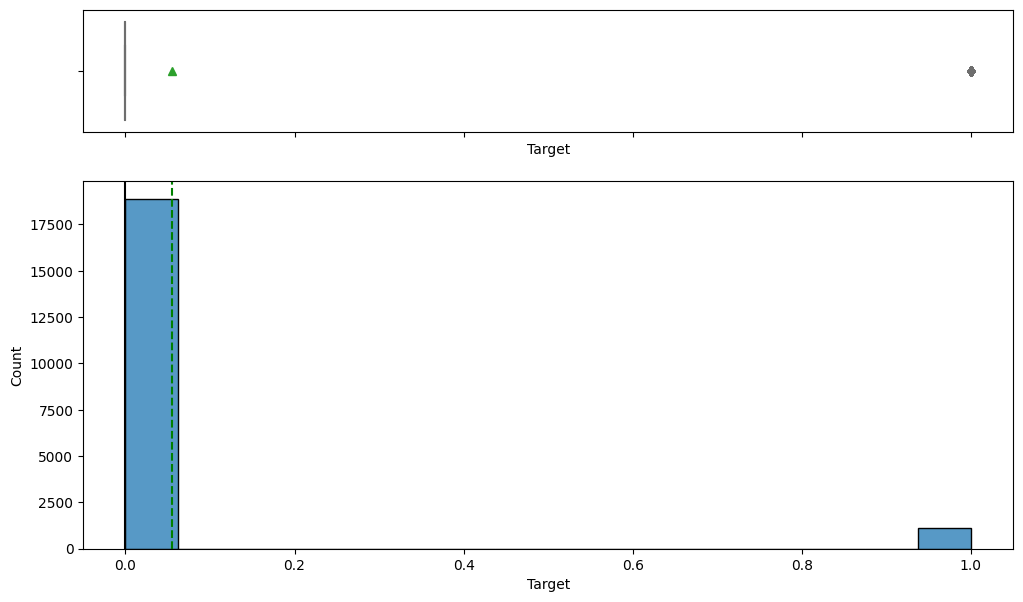

In [ ]:
# loop variables through and plot histograms & boxplots
for feature in train_df.columns:
    histogram_boxplot(train_df, feature, figsize=(12, 7), kde=False, bins=None)

### Check balance of target variable

In [ ]:
# show normalized target variable of train data
train_df['Target'].value_counts(normalize=True)

0    0.9445
1    0.0555
Name: Target, dtype: float64

In [ ]:
# show normalized target variable of test data
test_df['Target'].value_counts(normalize=True)

0    0.9436
1    0.0564
Name: Target, dtype: float64

### Observations on the dataset

- All features are numerical
- All features other than the target are nearly normally distributed
- All features have some outliers
  - We will not treat them as they are proper values
- The target is highly imbalanced with ~ 95% of the target variable being "1" or "failure"

*Data Limitations and Analysis Focus*
- The ciphered nature of the data presents unique challenges for traditional data analysis techniques
- Traditional methods like scatter plots and correlation analysis may not be applicable due to the inability to directly interpret ciphered features
- The analysis will primarily focus on feature importance and model-based insights

## Data Pre-processing

In [ ]:
# split target from train dataset
X = train_df.drop(["Target"], axis=1)
y = train_df["Target"]

In [ ]:
# split train dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in validation data =", X_val.shape[0])

Number of rows in train data = 15000
Number of rows in validation data = 5000


In [ ]:
# split target from test dataset
X_test = test_df.drop(["Target"], axis=1)
y_test = test_df["Target"]
print("Number of rows in test data =", X_test.shape[0])

Number of rows in test data = 5000


## Missing value imputation




In [ ]:
# define simple imputer
imputer = SimpleImputer(strategy='median')

In [ ]:
# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation & test data
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

In [ ]:
# check missing values
df_dict = {'X_train': X_train, 'X_val': X_val, 'X_test': X_test}

for name, df in df_dict.items():
    if df.isnull().values.any():
        print(f"{name}: {df.isna().sum()}")
    else:
        print(f"{name}: No missing values")

X_train: No missing values
X_val: No missing values
X_test: No missing values


## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1

        },
        index=[0],
    )

    return df_perf

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [ ]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

In [ ]:
models = []  # list to store the models

# append models to the list
models.append(("Decision Tree", DecisionTreeClassifier(random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=1)))
models.append(("XG Boosting", XGBClassifier(random_state=1)))

results1 = []  # list to store all model's CV scores
names = []  # list to store name of the models

# loop through models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset: \n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # set number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset: 

Decision Tree: 0.6982829521679532
Random Forest: 0.7235192266070268
Logistic regression: 0.4927566553639709
Adaboost: 0.6309140754635308
Gradient Boosting: 0.7066661857008874
XG Boosting: 0.8100497799581561

Validation Performance:

Decision Tree: 0.7050359712230215
Random Forest: 0.7266187050359713
Logistic regression: 0.48201438848920863
Bagging: 0.7302158273381295
Adaboost: 0.6762589928057554
Gradient Boosting: 0.7230215827338129
XG Boosting: 0.8309352517985612


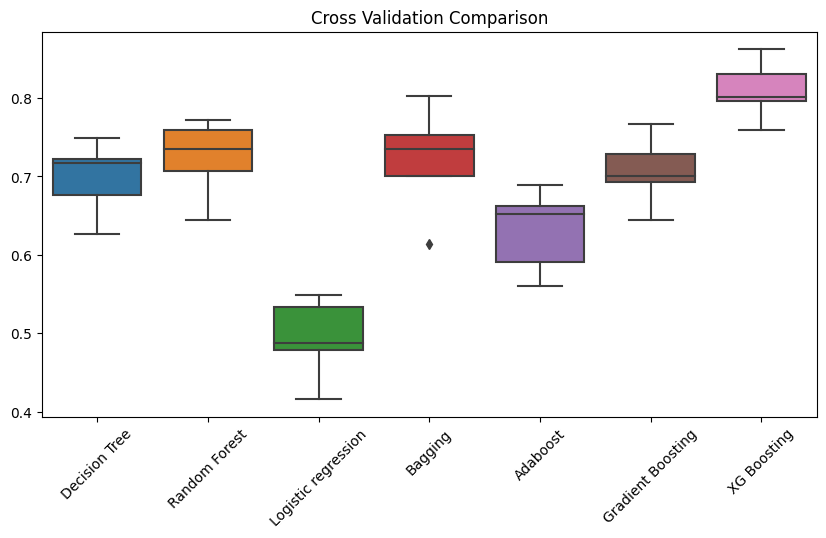

In [ ]:
# boxplot of CV scores
plt.figure(figsize=(10, 5))
plt.title('Cross Validation Comparison')
sns.boxplot(results1)
plt.xticks(range(len(names)), names, rotation=45)
plt.show();

**Best Model:** XGBoost model is slightly under-fitting but returns the best performance metrics.

### Model Building with Oversampled data


In [ ]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [ ]:
# display results
print("Before OverSampling, count of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, count of label '0': {} \n".format(sum(y_train == 0)))

print("After OverSampling, count of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, count of label '0': {} \n".format(sum(y_train_over == 0)))

print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, count of label '1': 832
Before OverSampling, count of label '0': 14168 

After OverSampling, count of label '1': 14168
After OverSampling, count of label '0': 14168 

After OverSampling, the shape of train_X: (28336, 40)
After OverSampling, the shape of train_y: (28336,) 



In [ ]:
models_over = []  # list to store the models

# append models to the list
models_over.append(("Decision Tree", DecisionTreeClassifier(random_state=1)))
models_over.append(("Random Forest", RandomForestClassifier(random_state=1)))
models_over.append(("Logistic Regression", LogisticRegression(random_state=1)))
models_over.append(("Bagging", BaggingClassifier(random_state=1)))
models_over.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_over.append(("Gradient Boosting", GradientBoostingClassifier(random_state=1)))
models_over.append(("XG Boosting", XGBClassifier(random_state=1)))

results_over = []  # list to store all model's CV scores
names_over = []  # list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models_over:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # set number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results_over.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Decision Tree: 0.9720494245534969
Random Forest: 0.9839075260047615
Logistic Regression: 0.883963699328486
Bagging: 0.9762141471581656
Adaboost: 0.8978689011775473
Gradient Boosting: 0.9256068151319724
XG Boosting: 0.9891305241357218

Validation Performance:

Decision Tree: 0.7769784172661871
Random Forest: 0.8489208633093526
Logistic Regression: 0.8489208633093526
Bagging: 0.8345323741007195
Adaboost: 0.8561151079136691
Gradient Boosting: 0.8776978417266187
XG Boosting: 0.8669064748201439


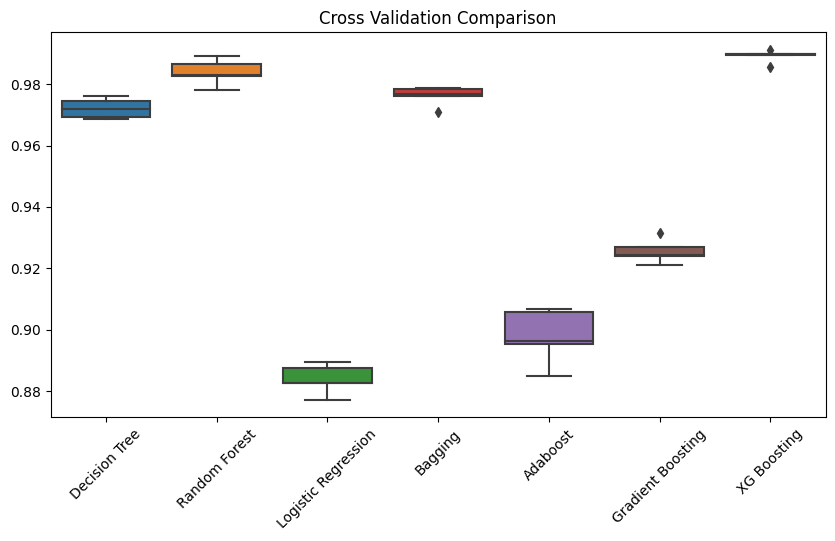

In [ ]:
# boxplot of CV scores
plt.figure(figsize=(10, 5))
plt.title('Cross Validation Comparison')
sns.boxplot(results_over)
plt.xticks(range(len(names_over)), names_over, rotation=45)
plt.show();

**Best Models**
- Gradient Boosting model is slightly over-fitting but returning the highest performance recall on validation dataset using oversampled data
- Adaboost model is most most fit model on oversampled data

### Model Building with Undersampled data

In [ ]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [ ]:
# display results
print("Before Under Sampling, count of label '1': {}".format(sum(y_train == 1)))
print("Before Under Sampling, count of label '0': {} \n".format(sum(y_train == 0)))

print("After Under Sampling, count of label '1': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, count of label '0': {} \n".format(sum(y_train_un == 0)))

print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Under Sampling, count of label '1': 832
Before Under Sampling, count of label '0': 14168 

After Under Sampling, count of label '1': 832
After Under Sampling, count of label '0': 832 

After Under Sampling, the shape of train_X: (1664, 40)
After Under Sampling, the shape of train_y: (1664,) 



In [ ]:
models_under = []  # list to store the models

# append models to the list
models_under.append(("Decision Tree", DecisionTreeClassifier(random_state=1)))
models_under.append(("Random Forest", RandomForestClassifier(random_state=1)))
models_under.append(("Logistic regression", LogisticRegression(random_state=1)))
models_under.append(("Bagging", BaggingClassifier(random_state=1)))
models_under.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_under.append(("Gradient Boosting", GradientBoostingClassifier(random_state=1)))
models_under.append(("XG Boosting", XGBClassifier(random_state=1)))

results_under = []  # list to store all model's CV scores
names_under = []  # list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models_under:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # set number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results_under.append(cv_result)
    names_under.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models_under:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Decision Tree: 0.8617776495202367
Random Forest: 0.9038669648654498
Logistic regression: 0.8726138085275232
Bagging: 0.8641945025611427
Adaboost: 0.8666113556020489
Gradient Boosting: 0.8990621167303946
XG Boosting: 0.9014717552846114

Validation Performance:

Decision Tree: 0.841726618705036
Random Forest: 0.8920863309352518
Logistic regression: 0.8525179856115108
Bagging: 0.8705035971223022
Adaboost: 0.8489208633093526
Gradient Boosting: 0.8884892086330936
XG Boosting: 0.89568345323741


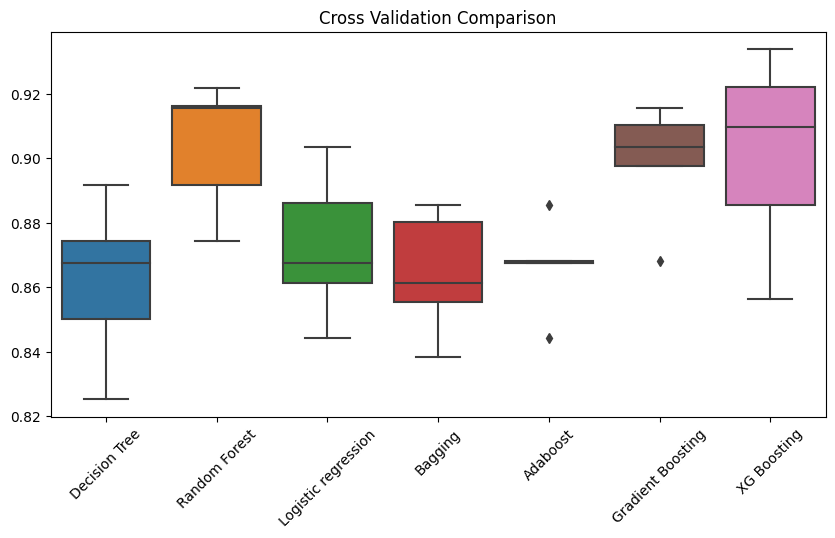

In [ ]:
# boxplot of CV scores
plt.figure(figsize=(10, 5))
plt.title('Cross Validation Comparison')
sns.boxplot(results_under)
plt.xticks(range(len(names_under)), names_under, rotation=45)
plt.show();

**Best Models**
- XG Boosting model is very slightly overfitting and returning the best recall score on undersampled, validation dataset
- Bagging model is very slightly underfitting and returning a recall score of ~ 0.871 on undersampled validation dataset

## HyperparameterTuning

### Tuning XGBoost with original data

In [ ]:
# defining model
Model = XGBClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250], 'scale_pos_weight': [5,10], 'learning_rate': [0.1,0.2], 'gamma': [0,3,5], 'subsample': [0.8,0.9] }

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs=-1, scoring=scorer, cv=5, random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

# set best parameters
best_params = randomized_cv.best_params_

# create tuned decision tree
xgb_tuned = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    scale_pos_weight=best_params['scale_pos_weight'],
    learning_rate=best_params['learning_rate'],
    gamma=best_params['gamma'],
    subsample=best_params['subsample']
)

# fit the tuned model
xgb_tuned.fit(X_train, y_train)

# display best params
print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.8546353076978572:


In [ ]:
# calc and display train performance
xgb_tuned_train_perf  = model_performance_classification_sklearn(xgb_tuned, X_train,y_train)
print("Training performance \n",xgb_tuned_train_perf)

Training performance 
    Accuracy  Recall  Precision        F1
0  0.998733     1.0   0.977673  0.988711


In [ ]:
# calc and display validation performance
xgb_tuned_val_perf  = model_performance_classification_sklearn(xgb_tuned, X_val,y_val)
print("Validation performance \n",xgb_tuned_val_perf)

Validation performance 
    Accuracy    Recall  Precision        F1
0    0.9892  0.859712   0.940945  0.898496


### Tuning Gradient Boosting with oversampled data

In [ ]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

# set best parameters
best_params = randomized_cv.best_params_

# create tuned random forest
gb_tuned_over = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    max_features=best_params['max_features']
)

# fit the tuned model
gb_tuned_over.fit(X_train_over, y_train_over)

# display best params
print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9723322092856124:


In [ ]:
# calc and display train performance
gb_tuned_over_train_perf  = model_performance_classification_sklearn(gb_tuned_over, X_train_over,y_train_over)
print("Training performance \n",gb_tuned_over_train_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.994071  0.994001   0.994141  0.994071


In [ ]:
# calc and display validation performance
gb_tuned_over_val_perf  = model_performance_classification_sklearn(gb_tuned_over, X_val,y_val)
print("Validation performance \n",gb_tuned_over_val_perf)

Validation performance 
    Accuracy    Recall  Precision        F1
0    0.9684  0.859712   0.667598  0.751572


### Tuning Adaboost with oversampled data

In [ ]:
# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),]
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

# set best parameters
best_params = randomized_cv.best_params_

# create tuned random forest
ada_tuned_over = AdaBoostClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    base_estimator=best_params['base_estimator']
)

# fit the tuned model
ada_tuned_over.fit(X_train_over, y_train_over)

# display best params
print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9714853746337214:


In [ ]:
# calc and display train performance
ada_tuned_over_train_perf  = model_performance_classification_sklearn(ada_tuned_over, X_train_over,y_train_over)
print("Training performance \n",ada_tuned_over_train_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.991777  0.988283   0.995238  0.991748


In [ ]:
# calc and display validation performance
ada_tuned_over_val_perf  = model_performance_classification_sklearn(ada_tuned_over, X_val,y_val)
print("Validation performance \n",ada_tuned_over_val_perf)

Validation performance 
    Accuracy    Recall  Precision        F1
0    0.9794  0.856115   0.790698  0.822107


### Tuning XGBoost with undersampled data

In [ ]:
# defining model
Model = XGBClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250], 'scale_pos_weight': [5,10], 'learning_rate': [0.1,0.2], 'gamma': [0,3,5], 'subsample': [0.8,0.9] }


# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

# set best parameters
best_params = randomized_cv.best_params_

# create tuned random forest
xgb_tuned_un = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    scale_pos_weight=best_params['scale_pos_weight'],
    learning_rate=best_params['learning_rate'],
    gamma=best_params['gamma'],
    subsample=best_params['subsample']
)

# fit the tuned model
xgb_tuned_un.fit(X_train_un, y_train_un)

# display best params
print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9290599523843879:


In [ ]:
# calc and display train performance
xgb_tuned_un_train_perf  = model_performance_classification_sklearn(xgb_tuned_un, X_train_un,y_train_un)
print("Training performance \n",xgb_tuned_un_train_perf)

Training performance 
    Accuracy  Recall  Precision        F1
0  0.972356     1.0   0.947608  0.973099


In [ ]:
# calc and display validation performance
xgb_tuned_un_val_perf  = model_performance_classification_sklearn(xgb_tuned_un, X_val,y_val)
print("Validation performance \n",xgb_tuned_un_val_perf)

Validation performance 
    Accuracy    Recall  Precision        F1
0    0.8234  0.917266     0.2287  0.366116


### Tuning Bagging with undersampled data

In [ ]:
# defining model
Model = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'max_samples': [0.8,0.9,1],
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

# set best parameters
best_params = randomized_cv.best_params_

# create tuned random forest
bagging_tuned_un = BaggingClassifier(
    max_samples=best_params['max_samples'],
    max_features=best_params['max_features'],
    n_estimators=best_params['n_estimators']
)

# fit the tuned model
bagging_tuned_un.fit(X_train_un, y_train_un)

# display best params
print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 70, 'max_samples': 0.9, 'max_features': 0.9} with CV score=0.8966236202294207:


In [ ]:
# calc and display train performance
bagging_tuned_un_train_perf  = model_performance_classification_sklearn(bagging_tuned_un, X_train_un,y_train_un)
print("Training performance \n",bagging_tuned_un_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
# calc and display validation performance
bagging_tuned_un_val_perf  = model_performance_classification_sklearn(bagging_tuned_un, X_val,y_val)
print("Validation performance \n",bagging_tuned_un_val_perf)

Validation performance 
    Accuracy    Recall  Precision        F1
0    0.9378  0.892086   0.468809  0.614622


## Model performance comparison and choosing the final model

In [ ]:
# Training performance comparison
models_train_comp_df = pd.concat(
    [
        xgb_tuned_train_perf.T,
        gb_tuned_over_train_perf.T,
        ada_tuned_over_train_perf.T,
        xgb_tuned_un_train_perf.T,
        bagging_tuned_un_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "XGBoost original",
    "Gradient Boosting  oversampled",
    "Adaboost oversampled",
    "XGBoost undersampled",
    "Bagging Estimator undersampled",
]

In [ ]:
# Validation performance comparison
models_val_comp_df = pd.concat(
    [
        xgb_tuned_val_perf.T,
        gb_tuned_over_val_perf.T,
        ada_tuned_over_val_perf.T,
        xgb_tuned_un_val_perf.T,
        bagging_tuned_un_val_perf.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "XGBoost original",
    "Gradient Boosting  oversampled",
    "Adaboost oversampled",
    "XGBoost undersampled",
    "Bagging Estimator undersampled",
]

In [ ]:
print("Tuned Models | Training performance comparison:")
models_train_comp_df

Tuned Models | Training performance comparison:


,XGBoost original,Gradient Boosting oversampled,Adaboost oversampled,XGBoost undersampled,Bagging Estimator undersampled
Accuracy,0.998733,0.994071,0.991777,0.972356,1.0
Recall,1.000000,0.994001,0.988283,1.000000,1.0
Precision,0.977673,0.994141,0.995238,0.947608,1.0
F1,0.988711,0.994071,0.991748,0.973099,1.0


In [ ]:
print("Tuned Models | Validation performance comparison:")
models_val_comp_df

Tuned Models | Validation performance comparison:


,XGBoost original,Gradient Boosting oversampled,Adaboost oversampled,XGBoost undersampled,Bagging Estimator undersampled
Accuracy,0.989200,0.968400,0.979400,0.823400,0.937800
Recall,0.859712,0.859712,0.856115,0.917266,0.892086
Precision,0.940945,0.667598,0.790698,0.228700,0.468809
F1,0.898496,0.751572,0.822107,0.366116,0.614622


- Though overfitting, the XGBoost model on the undersampled dataset is the best performing model from a recall standpoint

In [ ]:
# calc new column as (Recall + F1) / 2
models_val_comp_df = models_val_comp_df.T

# Calculate the new column 'Recall + F1 / 2'
models_val_comp_df['Recall & F1 Average'] = (models_val_comp_df['Recall'] + models_val_comp_df['F1']) / 2
models_val_comp_df['Recall & Precision Average'] = (models_val_comp_df['Recall'] + models_val_comp_df['Precision']) / 2


# Transpose the DataFrame back if needed
models_val_comp_df = models_val_comp_df.T
print("Tuned Models | Validation performance comparison:")
models_val_comp_df

Tuned Models | Validation performance comparison:


,XGBoost original,Gradient Boosting oversampled,Adaboost oversampled,XGBoost undersampled,Bagging Estimator undersampled
Accuracy,0.989200,0.968400,0.979400,0.823400,0.937800
Recall,0.859712,0.859712,0.856115,0.917266,0.892086
Precision,0.940945,0.667598,0.790698,0.228700,0.468809
F1,0.898496,0.751572,0.822107,0.366116,0.614622
Recall & F1 Average,0.879104,0.805642,0.839111,0.641691,0.753354
Recall & Precision Average,0.900329,0.763655,0.823406,0.572983,0.680448


- Though overfitting the XGBoost on the original dataset offers the best tradeoff between Recall, Precision, and F1 scores

### Test set final performance

- The XGBoost with original data will be used as the best performing model
- Recall score is not the highest but the trade off with higher Precision and F1 score offers beneficial cost savings in unnecessary inspections and maintenance

In [ ]:
# Calculating different metrics on validation set
xgb_tuned_test_perf = model_performance_classification_sklearn(xgb_tuned, X_test, y_test)
print("Test performance:")
xgb_tuned_test_perf

Test performance:


,Accuracy,Recall,Precision,F1
0,0.9882,0.847518,0.937255,0.89013


- The XGBoost model generalizes well with preformance metrics on test data similar to performance metrics on validation data
  - Relative Difference in Recall: (|0.859712 - 0.847518| / 0.859712) * 100% ≈ 1.42%
  - Relative Difference in Precision: (|0.940945 - 0.937255| / 0.940945) * 100% ≈ 0.39%
  - Relative Difference in F1-score: (|0.898496 - 0.89013| / 0.898496) * 100% ≈ 0.93%

### Feature Importance

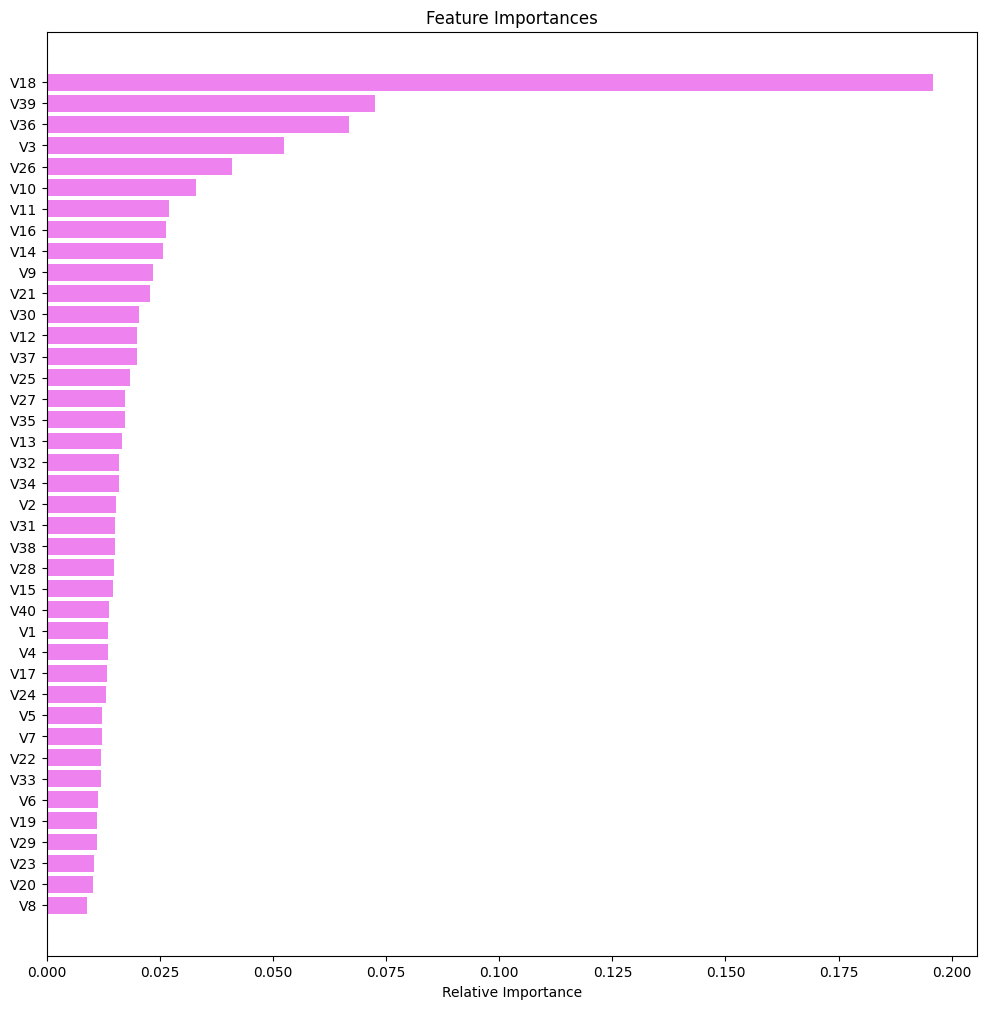

In [ ]:
# display feature importance
feature_names = X.columns
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [ ]:
# set feature importances to df
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df = feature_importance_df.reset_index(drop=True)

In [ ]:
# sum and display the top five importances
top_five_importance_sum = feature_importance_df.head()['Importance'].sum()
print("Sum of the top five importance scores:", top_five_importance_sum)

Sum of the top five importance scores: 0.4283463


In [ ]:
# convert importances to odds ratios and set to df
odds_ratios = np.exp(importances)
odds_ratio_df = pd.DataFrame({'Feature': feature_names, 'Odds Ratio': odds_ratios})
odds_ratio_df = odds_ratio_df.sort_values(by='Odds Ratio', ascending=False)
odds_ratio_df = odds_ratio_df.reset_index(drop=True)

In [ ]:
# view first five rows of odds ratios
odds_ratio_df.head()

,Feature,Odds Ratio
0,V18,1.216298
1,V39,1.075104
2,V36,1.068944
3,V3,1.053870
4,V26,1.041829


In [ ]:
# view last five rows of odds ratios
odds_ratio_df.tail()

,Feature,Odds Ratio
35,V19,1.011164
36,V29,1.011096
37,V23,1.010435
38,V20,1.010178
39,V8,1.008874


## Pipelines to build the final model


In [ ]:
# build pipeline for XGBoost model
pipeline_model = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),  # missing value treatment
    ('XGBoost', XGBClassifier(subsample= 0.8, scale_pos_weight= 10, n_estimators= 200, learning_rate= 0.1, gamma= 5))  # load best model
])

In [ ]:
# separate target variable and other variables in train and test data
X1 = train_df.drop(columns="Target")
Y1 = train_df["Target"]
X_test1 = test_df.drop(columns="Target")
y_test1 = test_df['Target']

In [ ]:
# fit model
pipeline_model.fit(X1, Y1)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('XGBoost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
# test data performance
pipeline_model_test = model_performance_classification_sklearn(pipeline_model, X_test1, y_test1)
pipeline_model_test

,Accuracy,Recall,Precision,F1
0,0.9868,0.843972,0.915385,0.878229


## Business Insights and Recommendations

### Model Evaluation and Feature Importance Report

- **Best Performing Model:** The XGBoost Tuned Model on original data
- **Recall Score:** ~0.84 on test data helps minimize false negatives, resulting in fewer replacements
- **Precision Score:** ~0.91 on test data helps minimize false positives, which can save costs associated with unnecessary inspections

- **Feature Importance** (*Insights on feature importance are based on the understanding that interpreting ciphered features has its limitations*)
  - **Top Five Features:** The top five features influencing the model are V18, V39, V36, V3, and V26
  - **Relative Importance:** The five most important features contribute to approximately 42.83% of the total importance
  - **Odds of Failure Increase:** Interpretation suggests that for these top five features:
    - V18 is associated with a 21.63% increase in the odds of failure for each one-unit increase in the feature
    - V39 is associated with a 7.51% increase in the odds of failure for each one-unit increase in the feature
    - V36 is associated with a 6.89% increase in the odds of failure for each one-unit increase in the feature
    - V3 is associated with a 5.39% increase in the odds of failure for each one-unit increase in the feature
    - V26 is associated with a 4.18% increase in the odds of failure for each one-unit increase in the feature

### Recommendations

- **Cost-Benefit Analysis:** Quantify replacement, repair, and inspection costs to better understand the trade-off between the three. This will help identify the optimal decision threshold for the model.
- **Effective Model Implementation:** Collaborate closely with the model developer to ensure seamless integration of the predictive maintenance model into your existing systems and processes.
- **Continuous Model Monitoring:** Establish a system for continuous model monitoring to track its performance over time. Implement alerts or notifications for significant changes in model accuracy or predictive power.
- **Data Quality and Enrichment:** Ensure the quality and completeness of the data used for model input. Consider data enrichment efforts to enhance the model's accuracy and predictive capabilities.
- **Employee Training and Awareness:** Conduct training sessions for relevant personnel to ensure they understand the model's recommendations and limitations. Empower employees to make informed decisions based on the model's insights.
- **Feedback Mechanism:** Establish a feedback mechanism that allows field personnel to provide input on the model's recommendations and their real-world effectiveness. Use this feedback to fine-tune the model and improve its alignment with operational needs.
- **Risk Mitigation Plans:** Develop contingency plans for potential equipment failures, even when the model predicts low risk. These plans should outline the steps to take in case of unexpected events to minimize disruptions and costs.
- **Strategic Alignment:** Ensure that the use of the predictive maintenance model aligns with your company's broader cost-saving and operational efficiency strategies.

### Conclusion

- The XGBoost Tuned Model shows promise in minimizing replacement, repair, and inspection costs by reducing false negatives and false positives. However, careful consideration of the trade-offs between replacement costs and inspection costs and continued data gathering and model refinement are essential for ongoing success.